# Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
!pip install tensorflow-hub
import tensorflow_hub as hub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0-rc2
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [3]:
!pip install pystan
!pip install fbprophet
from fbprophet import Prophet
import datetime
from datetime import datetime, timedelta

# Define Classes and Functions:

In [0]:
# Classification:
class KNN_Classifier():
    def __init__(self, X, y):  # Fit function
        self.X = X
        self.y = y

    def predict(self, X, k, epsilon):  # Calculate probability on new input
        N = len(X)
        y_hat = np.zeros(N)
        for i in range(N):
            dist2 = np.sum((self.X-X[i])**2, axis=1)
            idxt = np.argsort(dist2)[:k]
            gamma_k = (np.sqrt(dist2[idxt]) + epsilon)**-1
            y_hat[i] = np.bincount(self.y[idxt], weights=gamma_k).argmax()

        return y_hat  # return y_hat, i.e. argmax(P_hat)

def accuracy(y, y_hat):
    return np.mean(y == y_hat)

In [0]:
# Single LSTM:
def create_dataset(dataset, look_back):
  scaler = MinMaxScaler(feature_range=(0,1))
  dataset = scaler.fit_transform(dataset.reshape(-1,1))

  ds_size = int(len(dataset))
  dataset = dataset[:ds_size,:]

  dataX, dataY =[],[]
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])

  outX, outY = np.array(dataX), np.array(dataY)
  outX = np.reshape(outX, (outX.shape[0], 1, outX.shape[1]))
  return outX, outY


def ts_lstm_model(Y_in, look_back, epochs):

  batch_size = 1

  np.random.seed(7)
  dataset = Y_in.astype('float32')

  trainX, trainY = create_dataset(dataset, look_back)

  # LSTM Creation
  tf.keras.backend.clear_session()

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(10, input_shape=(1, look_back)))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  # print(model.summary())

  model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
  
  return model

In [0]:
#
def days_between(d1, d2):
  return abs((d2-d1) + 1)


def weekly_forecast(df, holidays, growth, holidays_prior_scale=10, n_changepoints=25, changepoint_prior_scale=0.05,
                   changepoints=None, interval_width=0.8, mcmc_samples=1, future_num_points=10, daily_seasonality=True,
                    weekly_seasonality=True, yearly_seasonality=True, plot_stuff=False):
  df_c = df.copy()
  m = Prophet(growth = growth,
              n_changepoints = n_changepoints,
              changepoint_prior_scale = changepoint_prior_scale,
              changepoints = changepoints,
              holidays = holidays,
              holidays_prior_scale = holidays_prior_scale,
              interval_width = interval_width,
              mcmc_samples = mcmc_samples, 
              daily_seasonality = daily_seasonality,
              weekly_seasonality = weekly_seasonality,
              yearly_seasonality = yearly_seasonality)
  m.fit(df_c)
  future = m.make_future_dataframe(periods=future_num_points, freq = 'W')
  forecast = m.predict(future)

  if plot_stuff:
    m.plot(forecast);
    m.plot_components(forecast)

  return forecast

# Models:

## KNN Classifier

In [7]:
# Read and define KNN Classifier
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Walmart KNN and Time Series/cleaned_walmart_store_data_train.csv")
print(data.head())
X_train = data.to_numpy()

y_ws_train = X_train[:, 14:15]  # Define Weekly_Sales for Regression
X_train = X_train[:, :-1]  # Chop off last column of X now that we've grabbed the labels.

# Build Store Select object from KNN_Classifier to feed to the LSTMs.
y_st_train = X_train[:, 1].astype(int, casting="unsafe")  # Define Store for Classifier.
X_train = np.delete(X_train, 1, axis=1)  # Get rid of Store labels from main set.

St_Sel = KNN_Classifier(X_train, y_st_train)

   Week_Number  Store  Type  ...  Unemployment  IsHoliday  Weekly_Sales
0            5      1     1  ...         8.106          0  16274.014118
1            5      2     1  ...         8.324          0  19557.478030
2            5      3     2  ...         7.368          0   4776.941875
3            5      4     1  ...         8.623          0  19435.180000
4            5      5     2  ...         6.566          0   5115.695161

[5 rows x 15 columns]


   Week_Number  Store  Type  ...  Unemployment  IsHoliday  Weekly_Sales
0          105      1     1  ...         7.348          0  15287.194328
1          105      2     1  ...         7.057          0  16147.132462
2          105      3     2  ...         6.833          0   4484.403333
3          105      4     1  ...         4.607          0  18279.000154
4          105      5     2  ...         5.943          0   4953.630317

[5 rows x 15 columns]
0.9574750830564784


(35.0, 0.0)

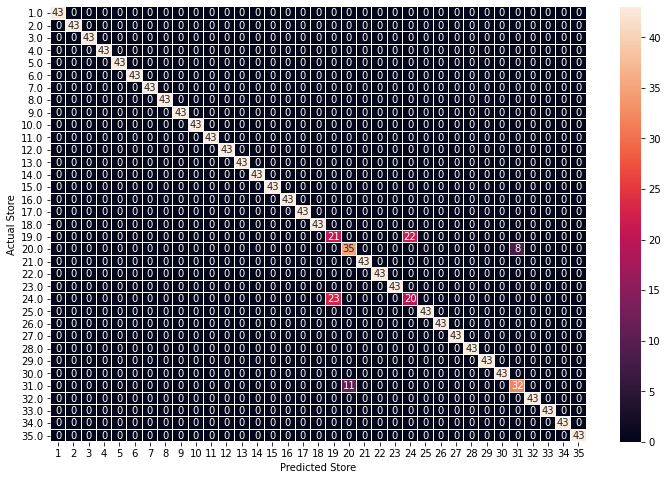

In [8]:
# Now evaluate the classifier with year 3 data.
# Hyperparameters:
k = 99
eps = 1e-10

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Walmart KNN and Time Series/cleaned_walmart_store_data_testyear3.csv")
print(data.head())
X_y3 = data.to_numpy()
y_ws_y3 = X_y3[:, -1]  # Define Weekly_Sales for Regression
X_y3 = X_y3[:, :-1]  # Chop off last column of X now that we've grabbed the labels
y_st_y3 = X_y3[:, 1]  # Define Store for Classifier
X_y3 = np.delete(X_y3, 1, axis=1)  # Get rid of Store labels from main set

# Test Classification and print Metrics
s_temp = St_Sel.predict(X_y3, k, eps).astype(int, casting="unsafe")

print(accuracy(y_st_y3, s_temp))
plt.figure(figsize=(12, 8))
y_true = pd.Series(y_st_y3, name="Actual Store")
y_pred = pd.Series(s_temp, name="Predicted Store")
sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt="d", linewidths=0.005)
plt.ylim(len(set(y_st_y3)), 0)  # Fix limits, matplotlib bugged (ver. 3.11)

## LSTM Model:

In [9]:
# Create LSTM Model for each store from the training set:
LSTM = []
look_back = 8
epochs = 5

# For each unique store make a unique LSTM
for i in range(1, len(np.unique(y_st_train[:])) + 1):  # Starts at Store ID 1:
    LSTM.append(ts_lstm_model(y_ws_train[y_st_train[:] == i],
                              look_back, epochs))
    print("Store " + str(i) + " LSTM completed!")
print("\nLSTM models successfully built!")

Store 1 LSTM completed!
Store 2 LSTM completed!
Store 3 LSTM completed!
Store 4 LSTM completed!
Store 5 LSTM completed!
Store 6 LSTM completed!
Store 7 LSTM completed!
Store 8 LSTM completed!
Store 9 LSTM completed!
Store 10 LSTM completed!
Store 11 LSTM completed!
Store 12 LSTM completed!
Store 13 LSTM completed!
Store 14 LSTM completed!
Store 15 LSTM completed!
Store 16 LSTM completed!
Store 17 LSTM completed!
Store 18 LSTM completed!
Store 19 LSTM completed!
Store 20 LSTM completed!
Store 21 LSTM completed!
Store 22 LSTM completed!
Store 23 LSTM completed!
Store 24 LSTM completed!
Store 25 LSTM completed!
Store 26 LSTM completed!
Store 27 LSTM completed!
Store 28 LSTM completed!
Store 29 LSTM completed!
Store 30 LSTM completed!
Store 31 LSTM completed!
Store 32 LSTM completed!
Store 33 LSTM completed!
Store 34 LSTM completed!
Store 35 LSTM completed!

LSTM models successfully built!


In [10]:
# Now evaluate new stores:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Walmart KNN and Time Series/cleaned_walmart_store_data_testnewstores.csv")
X_tns = data.to_numpy()
y_ws_tns = X_tns[:, -1]  # Define Weekly_Sales for Regression
X_tns = X_tns[:, :-1]  # Chop off last column of X now that we've grabbed the labels.
y_st_tns = X_tns[:, 1]  # Define Store for Classifier.
X_tns = np.delete(X_tns, 1, axis=1)  # Get rid of Store labels from main set.

# Map new stores to the closest known store:
store_map = np.zeros([len(np.unique(y_st_tns)), 2])
print(store_map.shape)

s_temp = St_Sel.predict(X_tns, k, eps).astype(int, casting="unsafe")
j = 0
for i in np.unique(y_st_tns[:]):  # Starts at Store ID 1:
  store_map[j, 0] = int(i)
  store_map[j, 1] = int(s_temp[y_st_tns == i].mean())
  j += 1

print(store_map)

(10, 2)
[[36. 33.]
 [37. 33.]
 [38. 33.]
 [39. 14.]
 [40.  8.]
 [41. 14.]
 [42. 33.]
 [43. 33.]
 [44. 33.]
 [45. 22.]]


36.0    0.7686878185727425


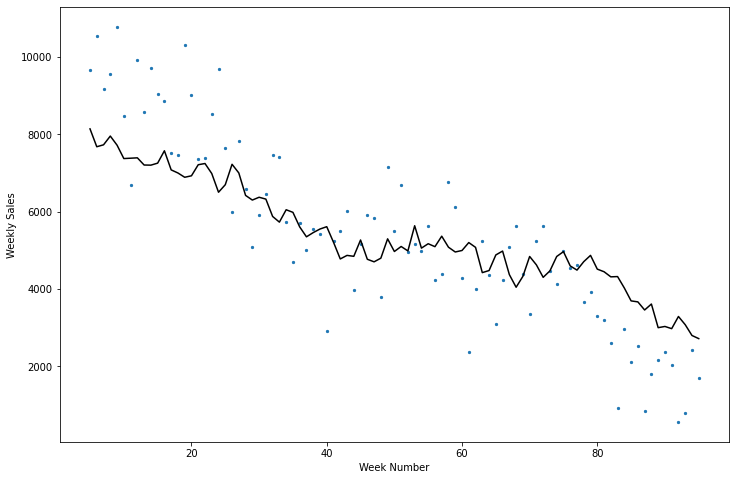

37.0    0.14747663690810126


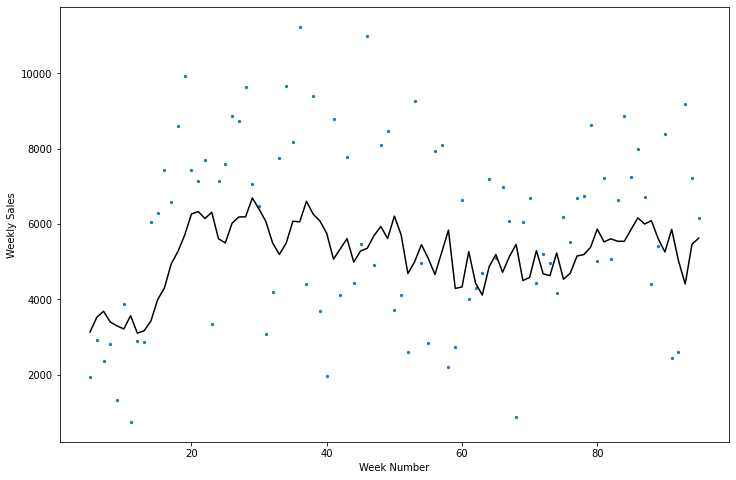

38.0    0.17372498518173465


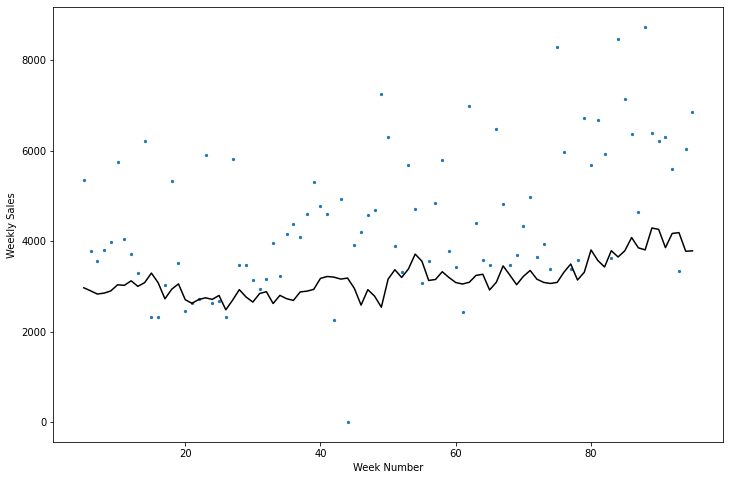

39.0    0.15181233244947082


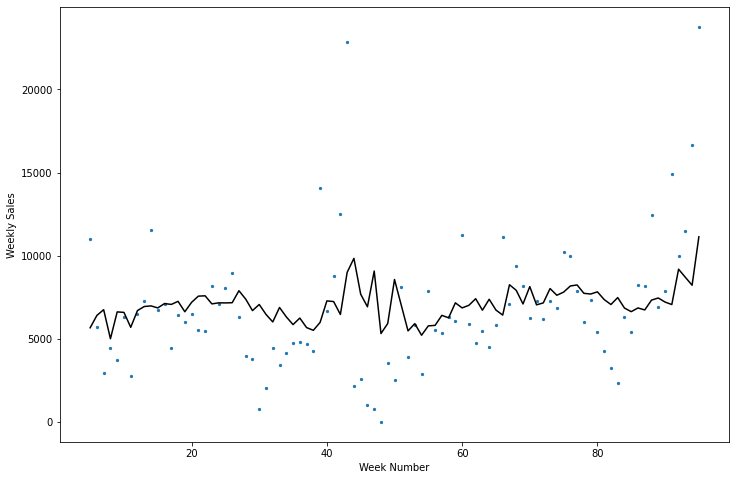

40.0    0.027546939378715544


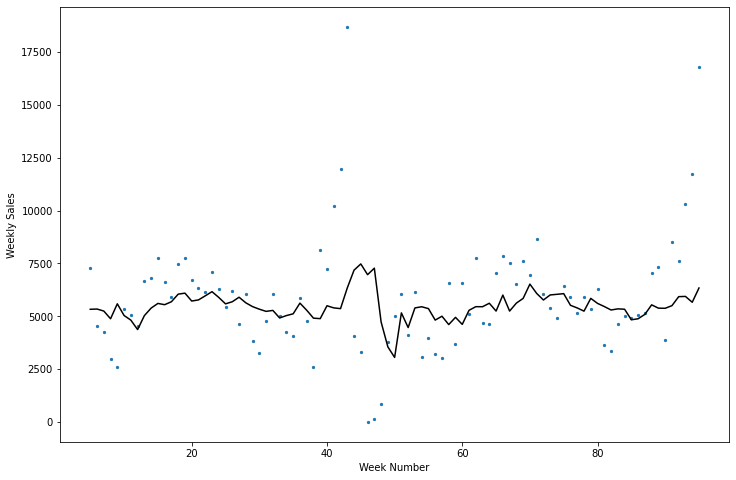

41.0    0.26209329791117986


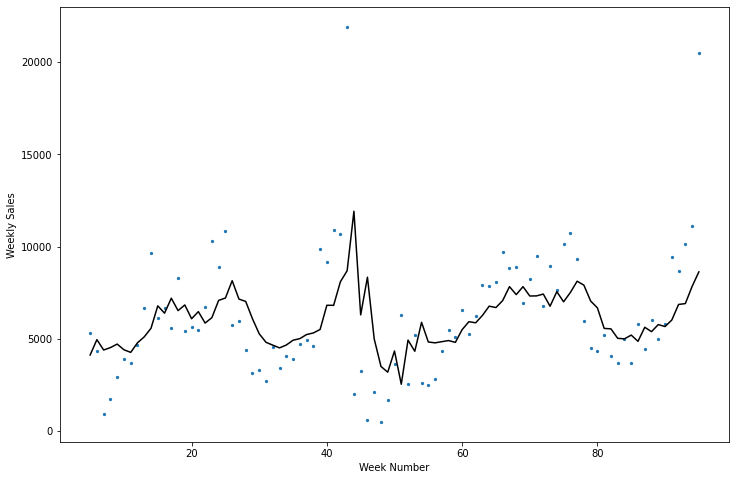

42.0    0.05987167956168293


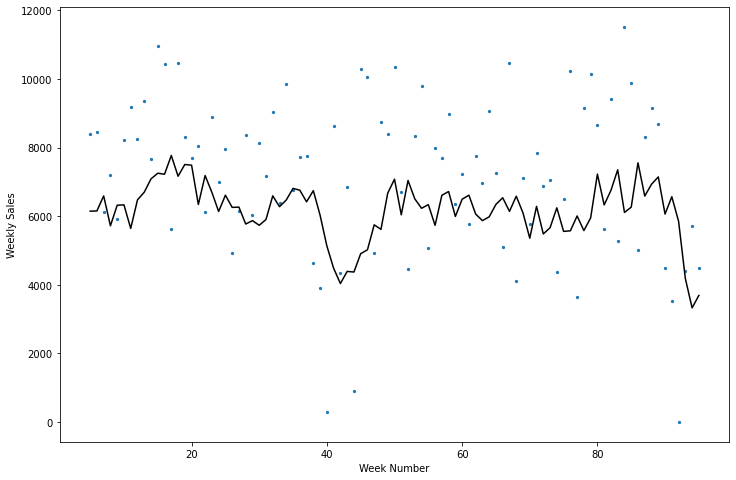

43.0    0.03845388927942287


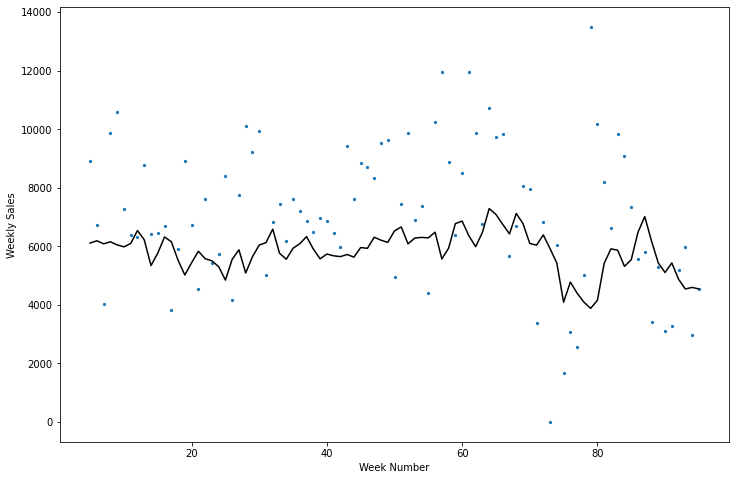

44.0    0.055110877406127357


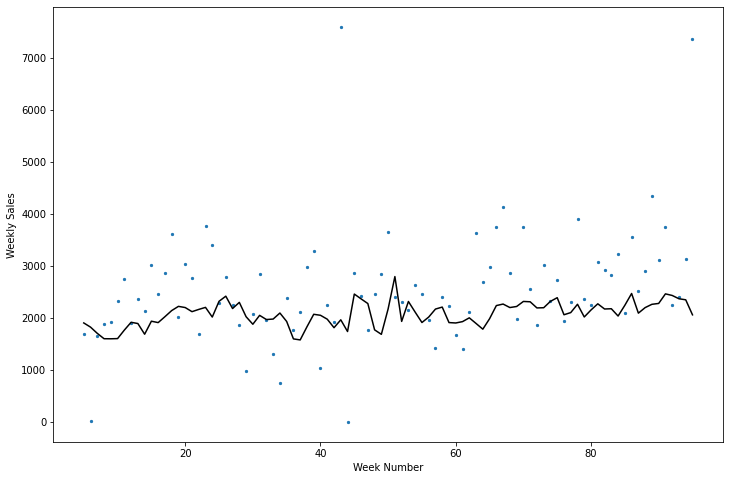

45.0    0.19513746619456068


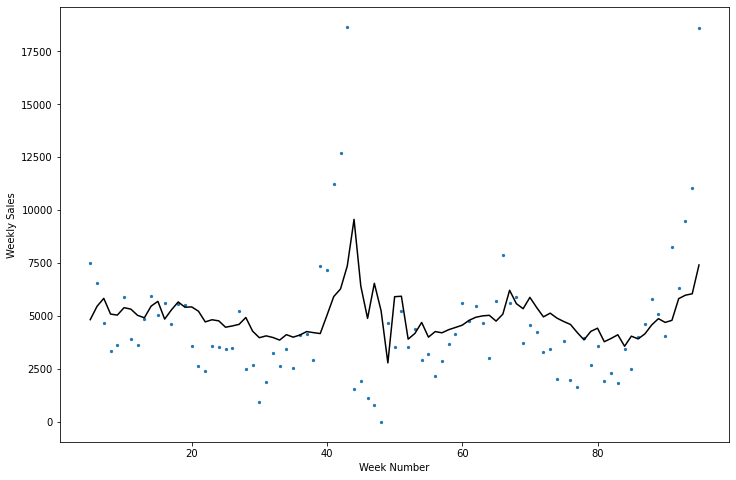

In [11]:
# Begin Prediction
R2 = []
MSE = []
for i in range(len(np.unique(y_st_tns))):  # For each unique store predicted, evaluate
  X_temp = X_tns[y_st_tns[:] == store_map[i, 0]]
  y_temp = y_ws_tns[y_st_tns[:] == store_map[i, 0]]
  scale = np.max(y_temp)
  y_testX, y_testY = create_dataset(y_temp, look_back)

  # y_hat = np.squeeze(LSTM[i].predict(y_testX))
  y_hat = np.squeeze(LSTM[i].predict(y_testX)) * scale
  y_testY = y_testY * scale

  R2.append(np.corrcoef(y_testY, y_hat)[0, 1]**2)
  MSE.append((np.square(y_testY - y_hat)).mean(axis=0))

  if R2[i] > 0.0:
    print(str(store_map[i, 0]) + "    " + str(R2[i]))
    plt.figure(figsize=(12, 8))
    plt.scatter(X_temp[:len(y_hat), 0], y_testY, s=5)
    plt.plot(X_temp[:len(y_hat), 0], y_hat, color='#000000')
    plt.xlabel('Week Number')
    plt.ylabel('Weekly Sales')
    plt.show()

In [12]:
print(R2)
r2 = np.max(R2)
print("LSTM Max R^2 Value: " + str(r2))
print(MSE)
mse = np.min(MSE)
print("LSTM MSE: " + str(mse))

[0.7686878185727425, 0.14747663690810126, 0.17372498518173465, 0.15181233244947082, 0.027546939378715544, 0.26209329791117986, 0.05987167956168293, 0.03845388927942287, 0.055110877406127357, 0.19513746619456068]
LSTM Max R^2 Value: 0.7686878185727425
[2031914.2954633308, 5498114.084196182, 3821343.1239616144, 13766883.998608988, 7501132.086025745, 9104546.980997473, 6018984.770050716, 7139449.741004133, 1350815.8379357879, 7728684.793246579]
LSTM MSE: 1350815.8379357879


1    0.005398740643663067


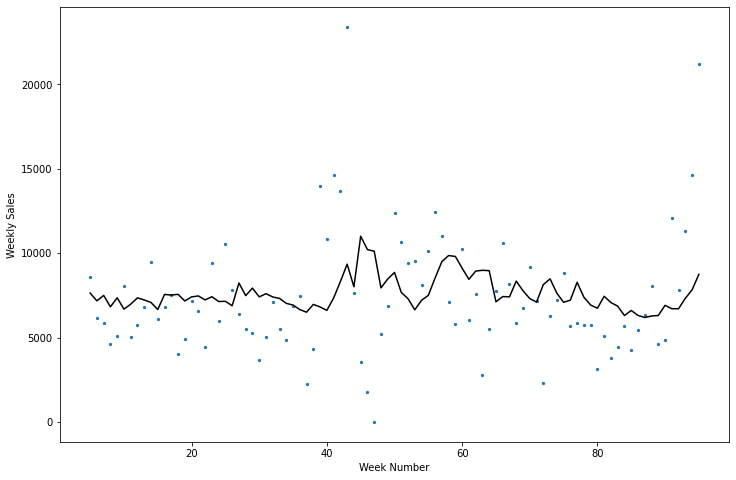

2    0.1487447134512864


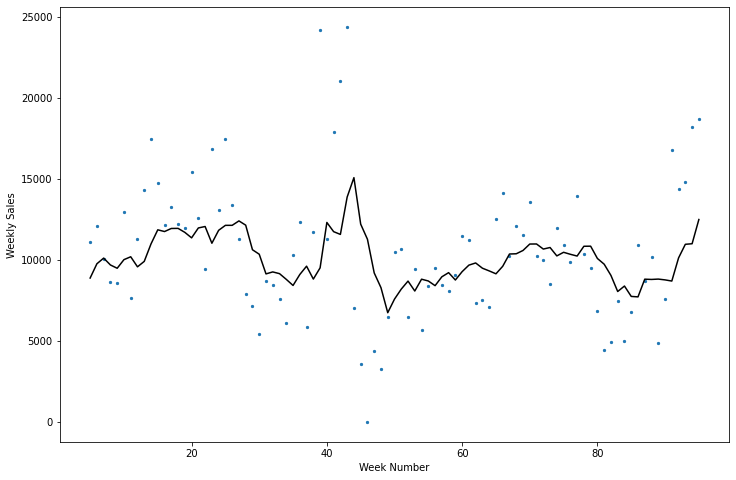

3    0.24803649143815334


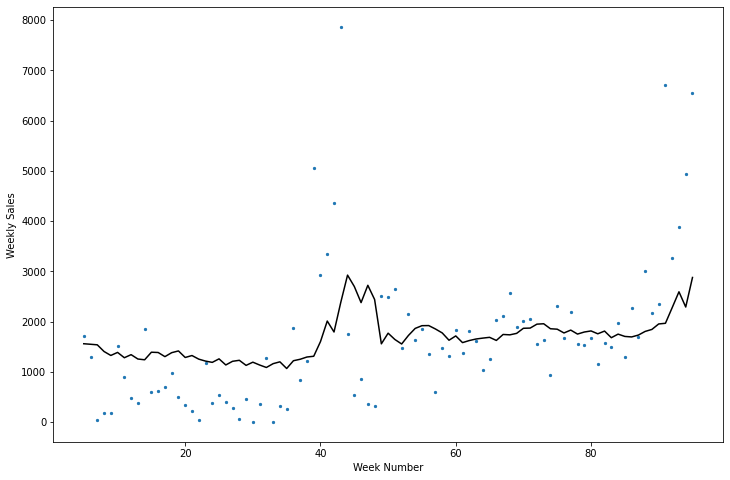

4    0.14724254839281406


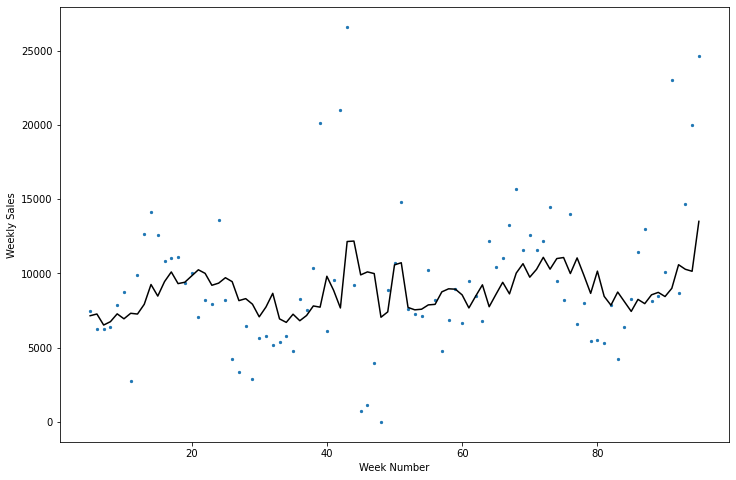

5    0.054922017261866615


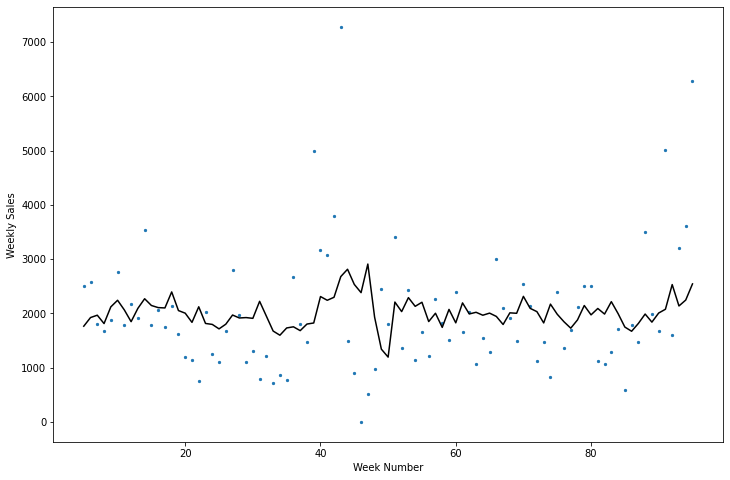

6    0.3660861629041817


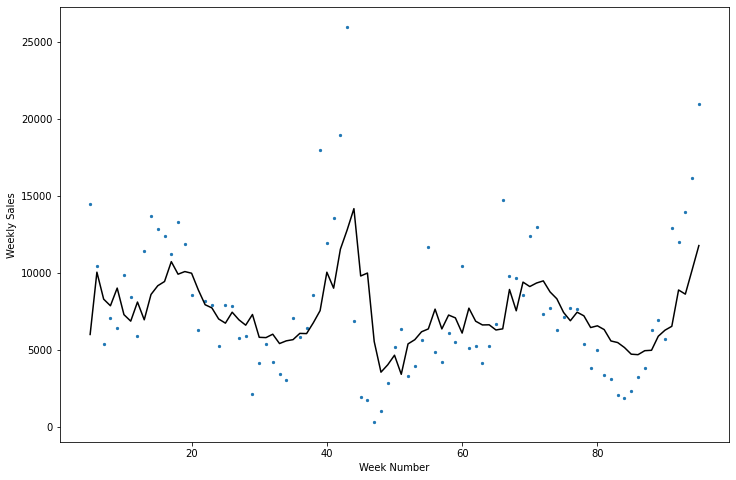

7    0.43450630212438623


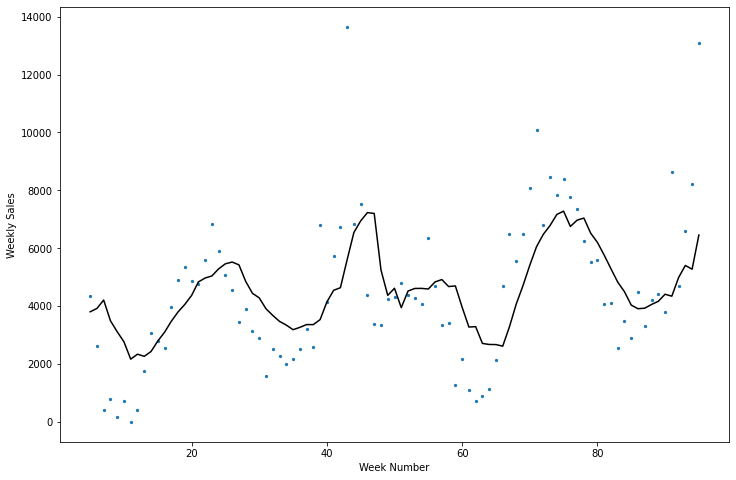

8    0.12727461185477174


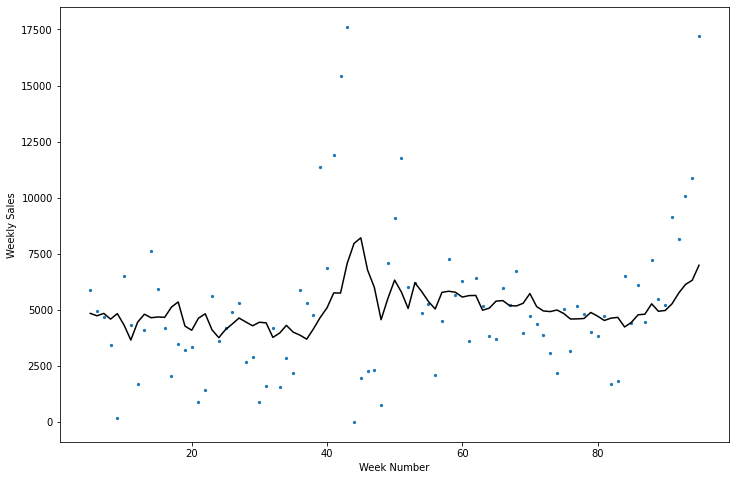

9    0.023240560457773927


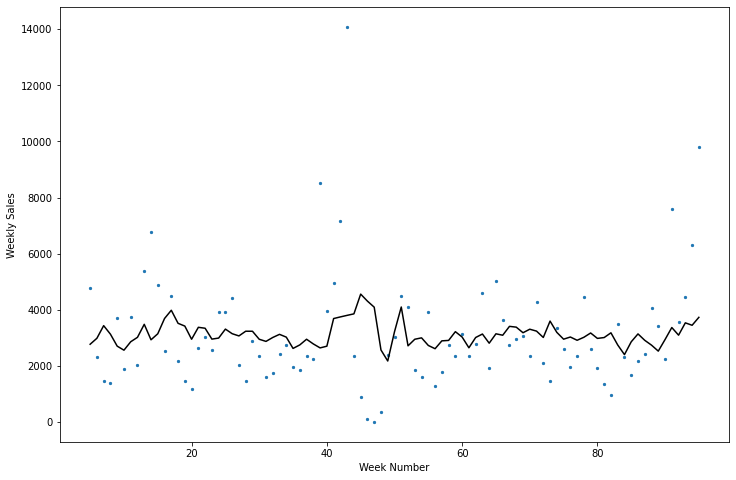

10    0.2502405990796624


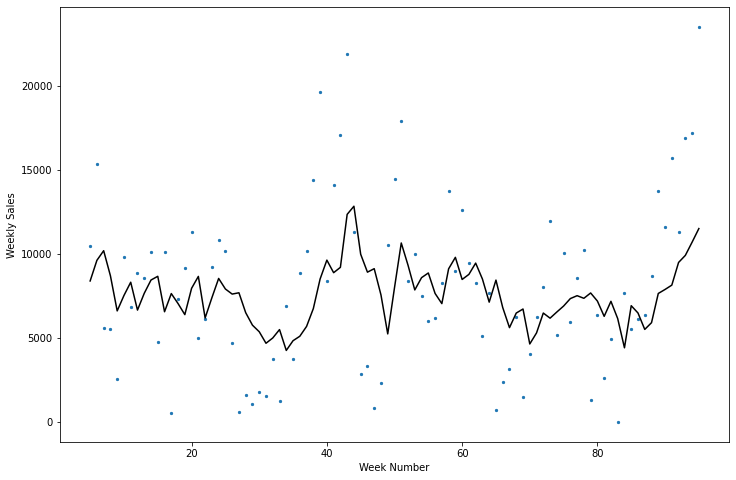

11    0.039329781621288765


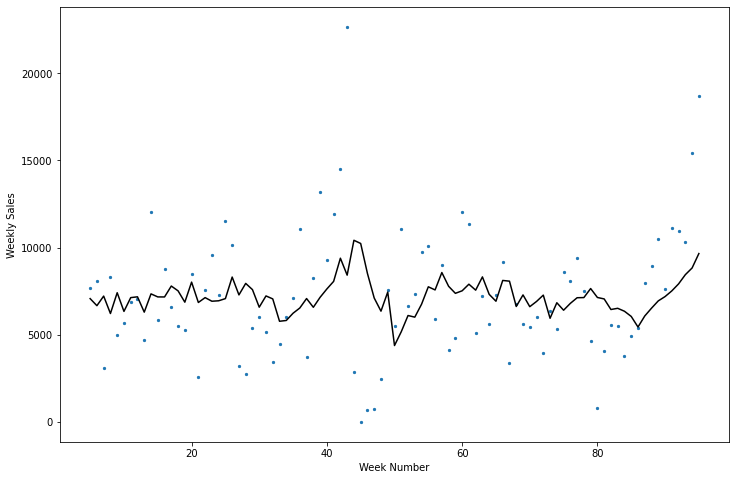

12    0.10938326347279208


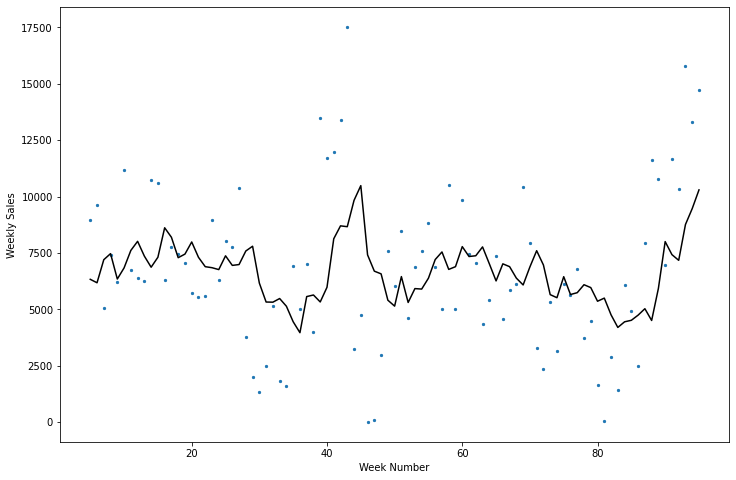

13    0.11228912167584519


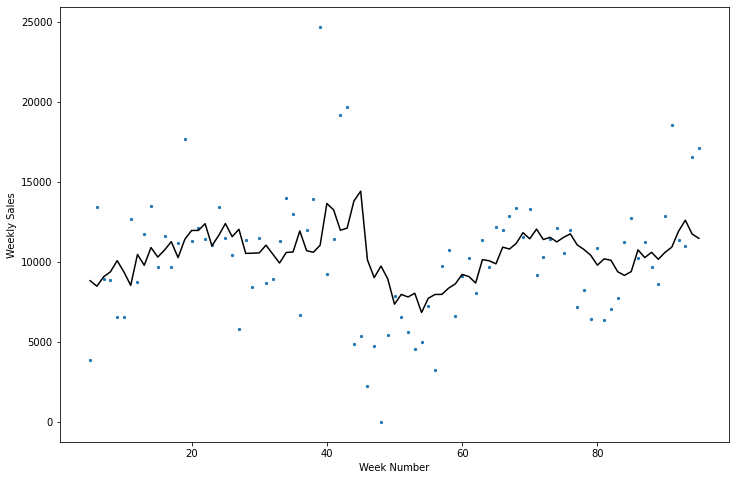

14    0.07494419732623513


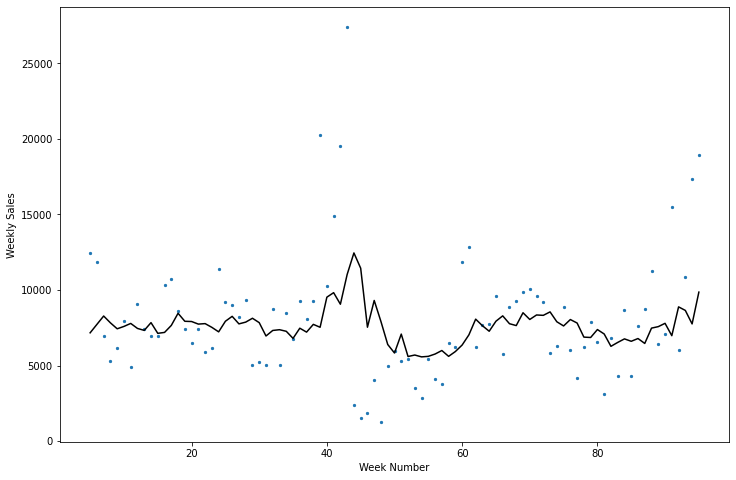

15    0.14603606406033406


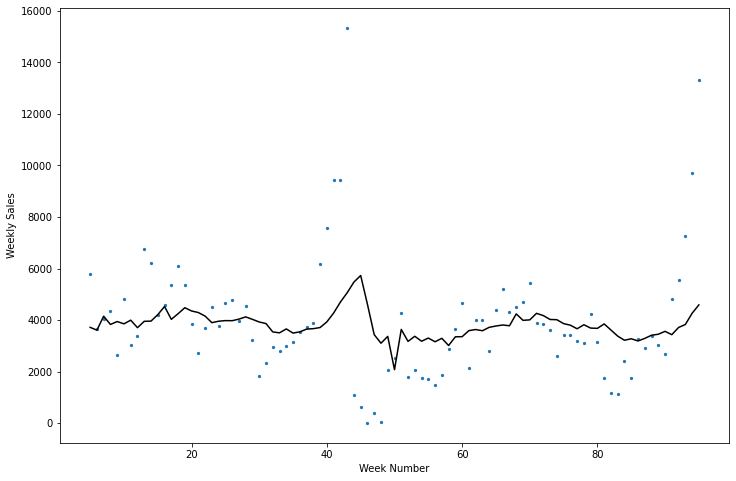

16    0.3196014627184088


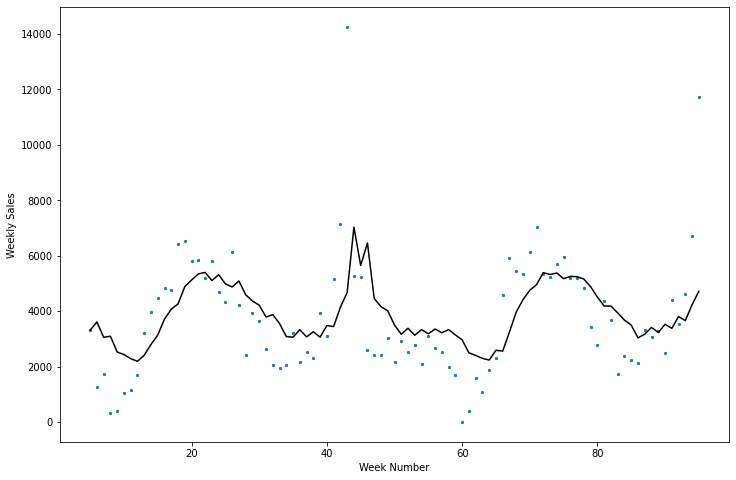

17    0.03579537616265101


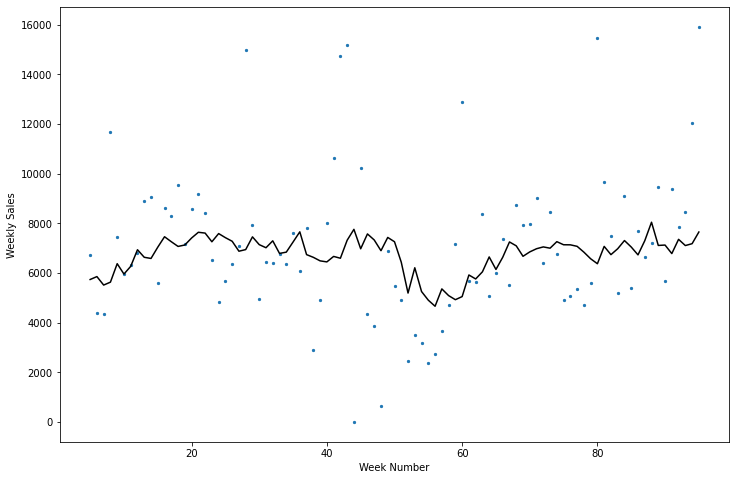

18    0.18032267888505002


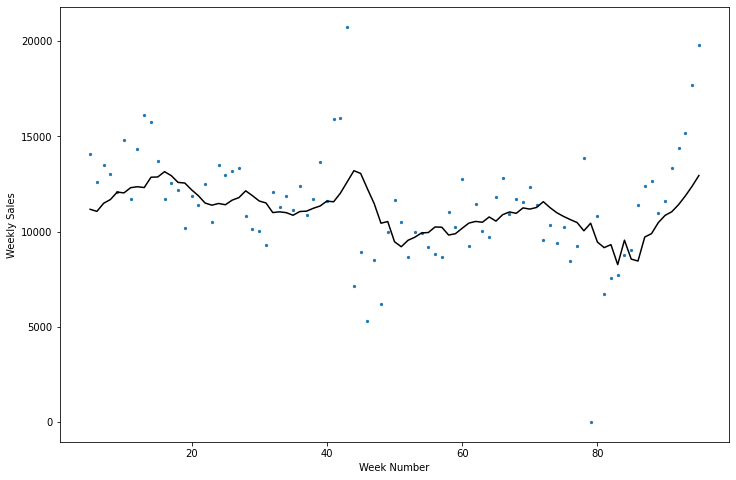

19    0.18258124599570127


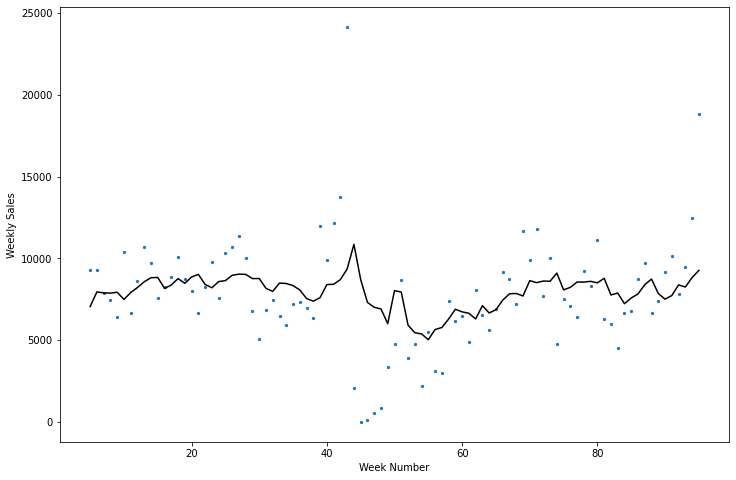

20    0.1975368912437151


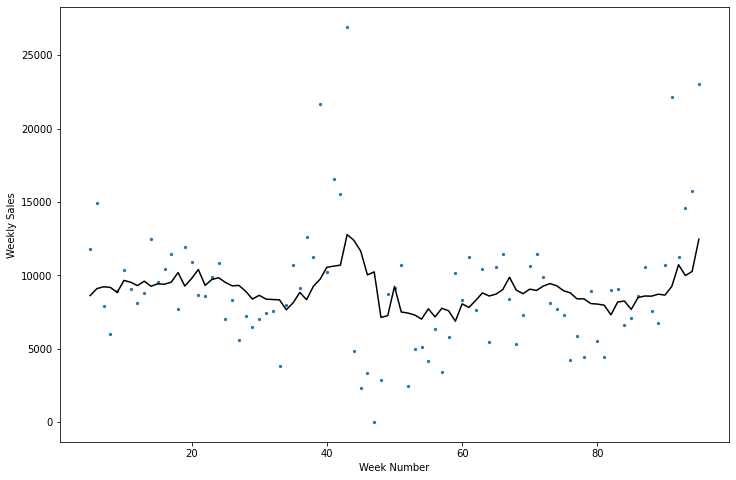

21    0.12907947688740704


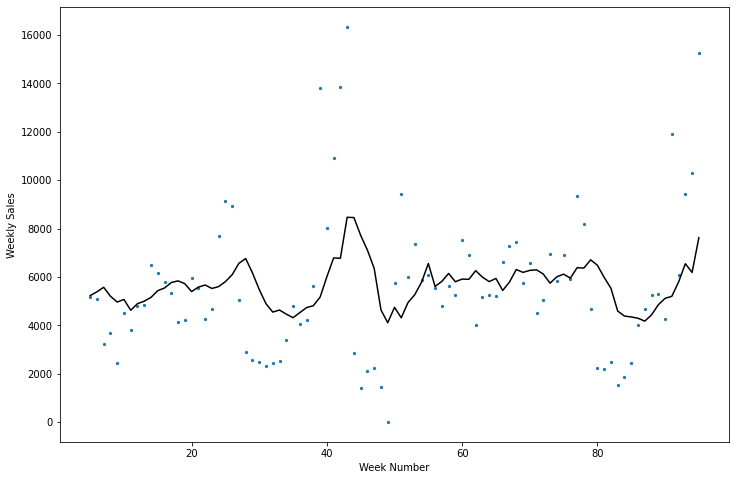

22    0.10252416632489236


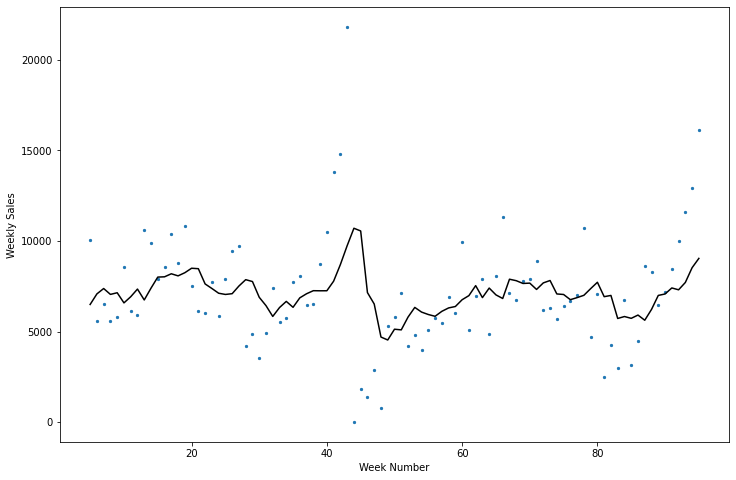

23    0.24511720751353397


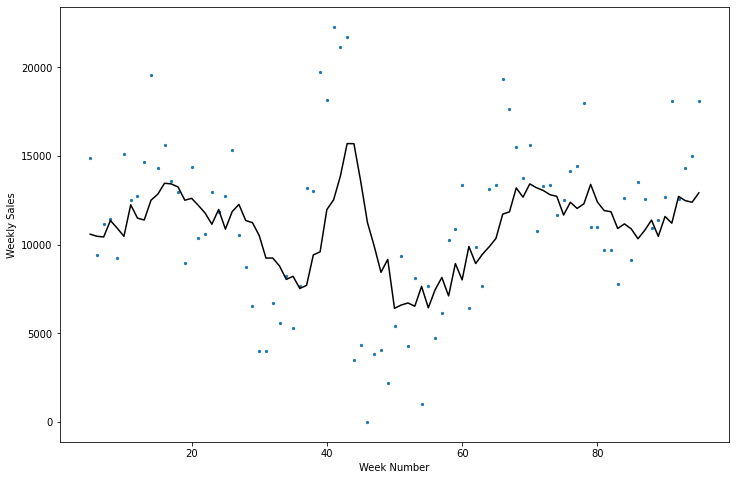

24    0.2837033660526699


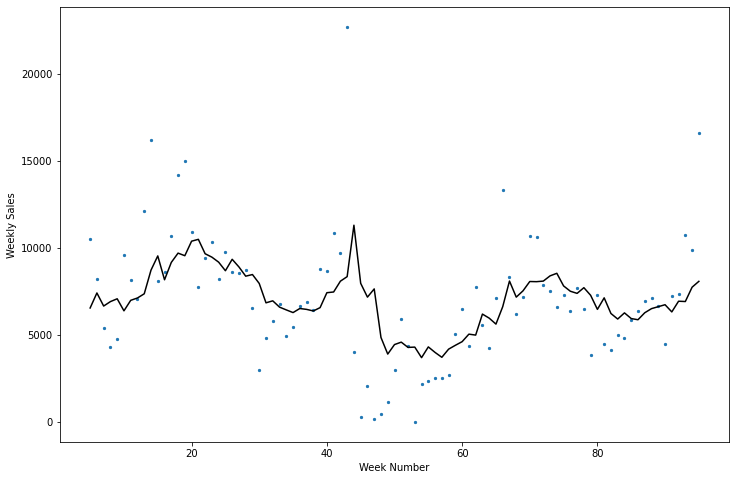

25    0.3667270179575791


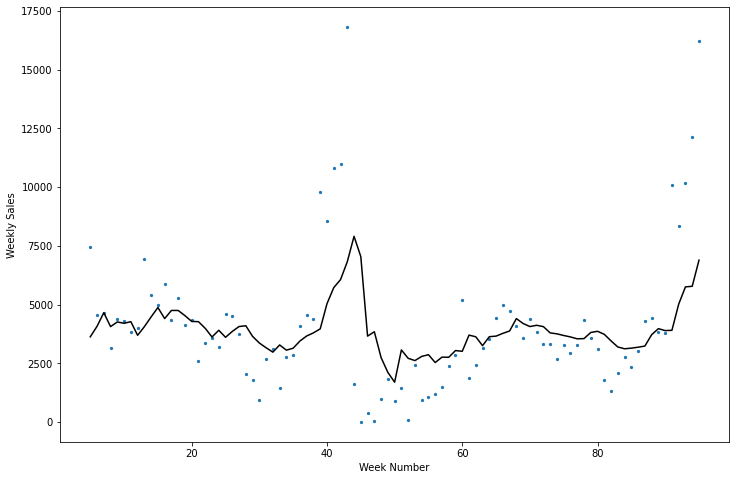

26    0.2878431032776026


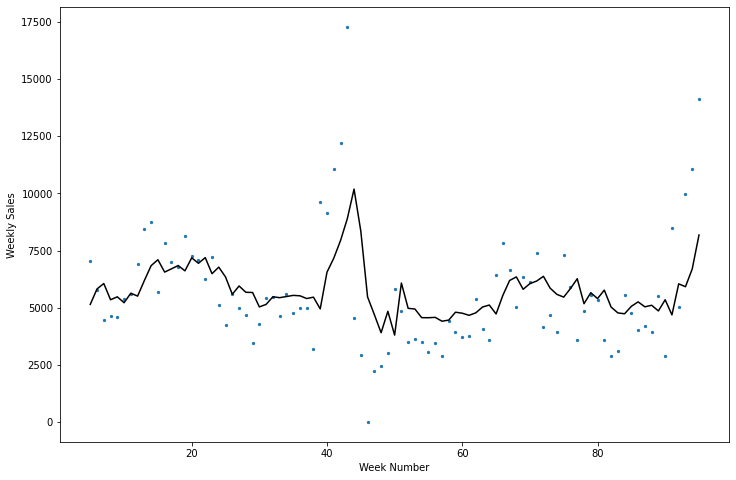

27    0.11302794344922704


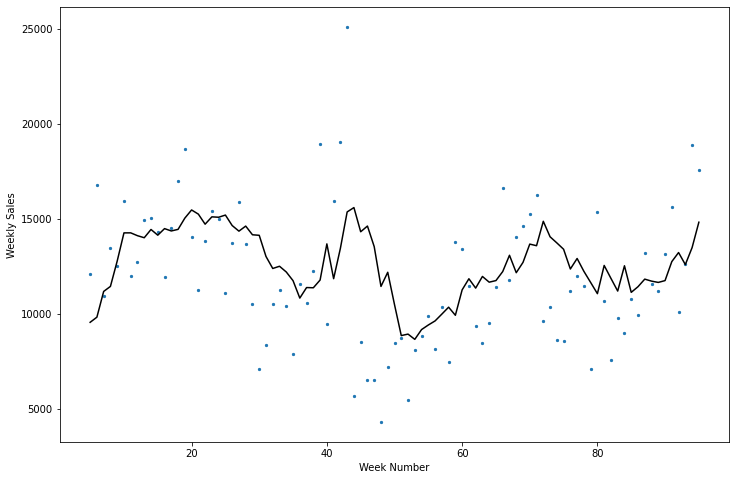

28    0.06968870162174834


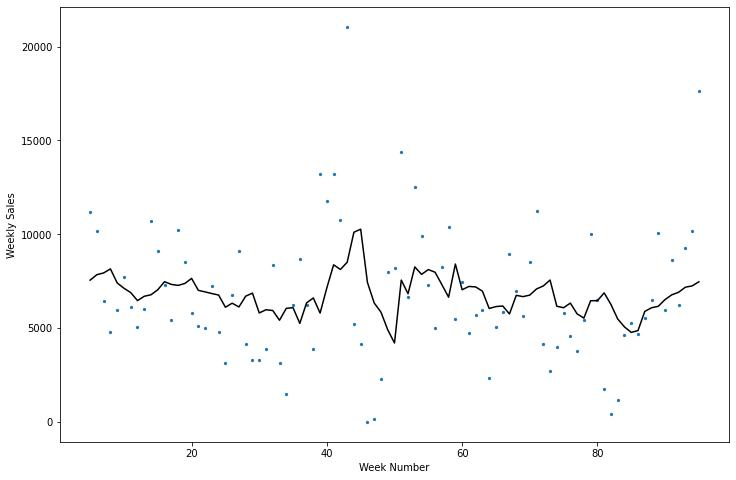

29    0.07088150719918855


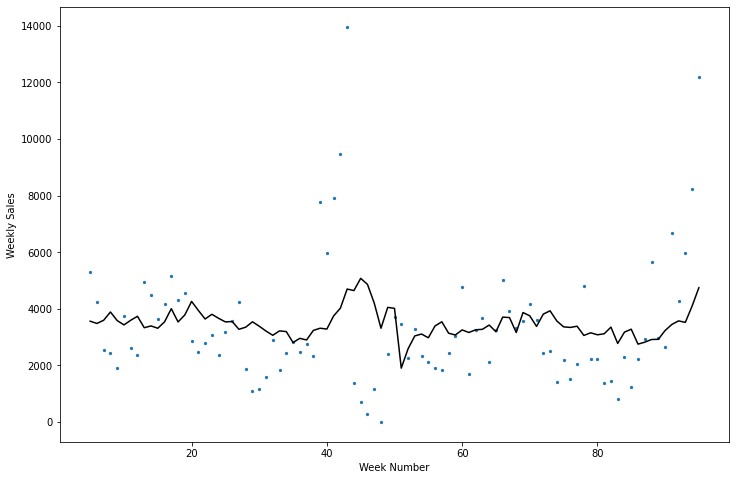

30    0.4120202975289558


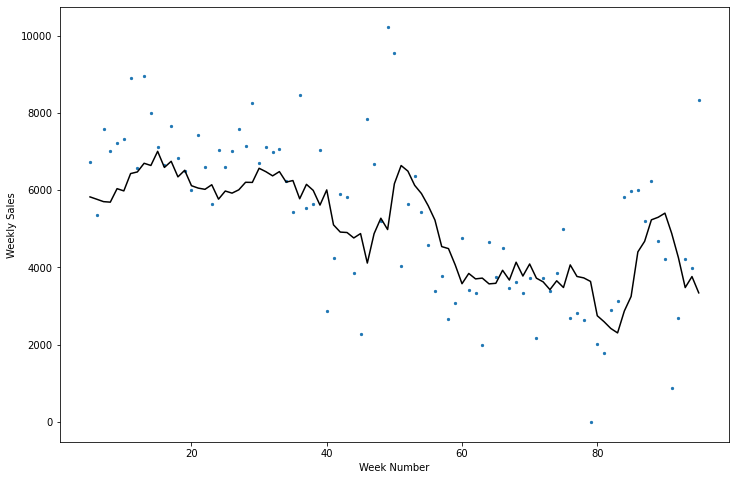

31    0.1099841070508279


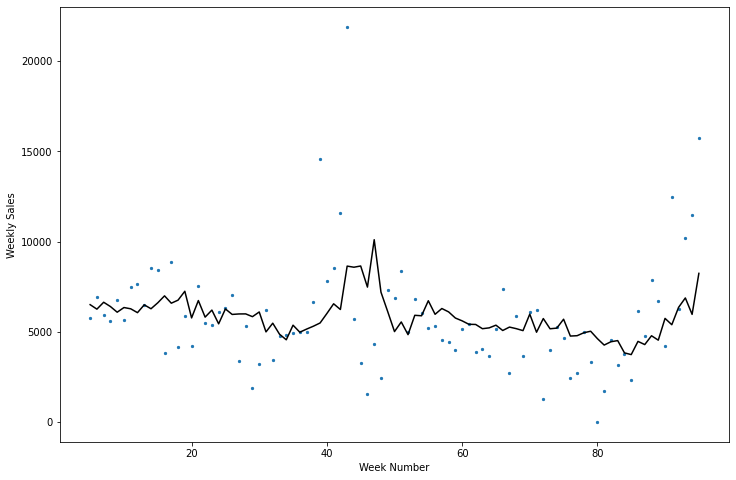

32    0.27502288298955496


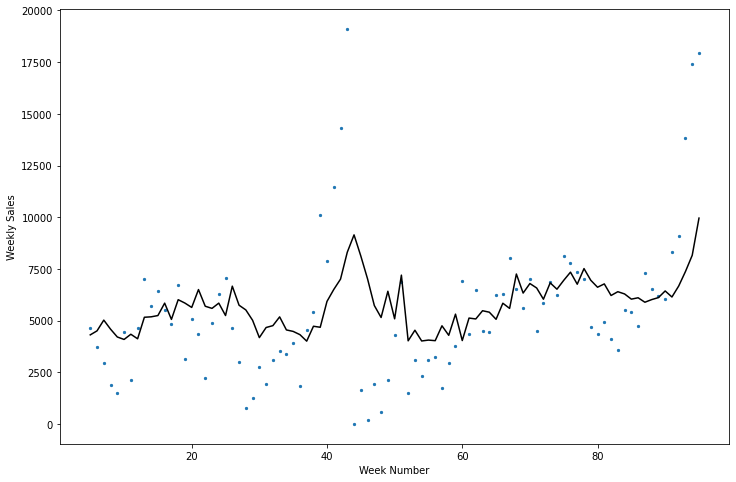

33    0.7193583128977715


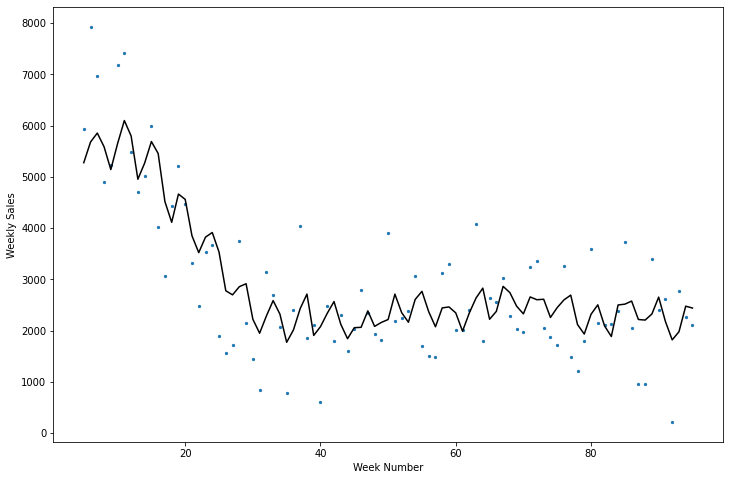

34    0.18042496126283


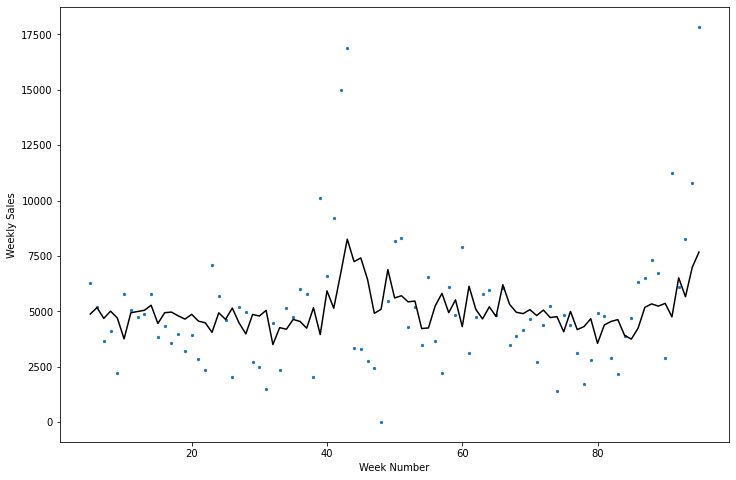

35    0.5539809262281358


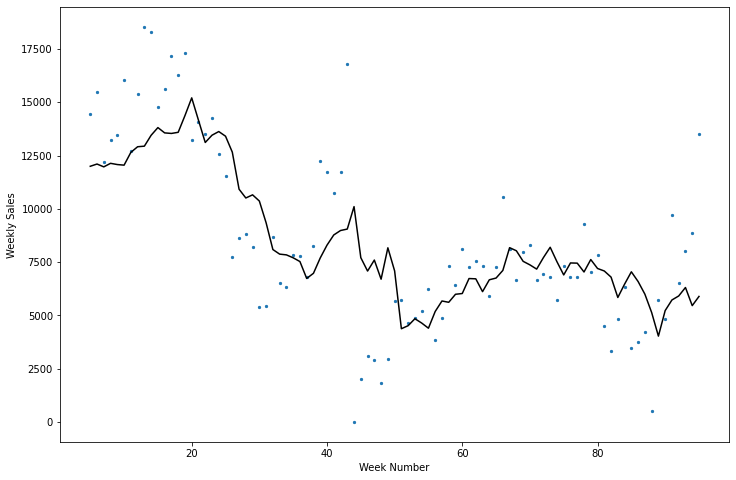

In [13]:
# And Existing Stores:
R2 = []
MSE = []
for i in range(len(np.unique(y_st_train))):  # For each unique store predicted, evaluate
  X_temp = X_train[y_st_train[:] == i+1]
  y_temp = y_ws_train[y_st_train[:] == i+1]
  scale = np.max(y_temp)
  y_testX, y_testY = create_dataset(y_temp, look_back)

  # y_hat = np.squeeze(LSTM[i].predict(y_testX))
  y_hat = np.squeeze(LSTM[i].predict(y_testX)) * scale
  y_testY = y_testY * scale

  R2.append(np.corrcoef(y_testY, y_hat)[0, 1]**2)
  MSE.append((np.square(y_testY - y_hat)).mean(axis=0))

  if R2[i] > 0.0:
    print(str(i+1) + "    " + str(R2[i]))
    plt.figure(figsize=(12, 8))
    plt.scatter(X_temp[:len(y_hat), 0], y_testY, s=5)
    plt.plot(X_temp[:len(y_hat), 0], y_hat, color='#000000')
    plt.xlabel('Week Number')
    plt.ylabel('Weekly Sales')
    plt.show()

In [14]:
print(R2)
r2 = np.max(R2)
print("LSTM Max R^2 Value: " + str(r2))
print(MSE)
mse = np.min(MSE)
print("LSTM MSE: " + str(mse))

[0.005398740643663067, 0.1487447134512864, 0.24803649143815334, 0.14724254839281406, 0.054922017261866615, 0.3660861629041817, 0.43450630212438623, 0.12727461185477174, 0.023240560457773927, 0.2502405990796624, 0.039329781621288765, 0.10938326347279208, 0.11228912167584519, 0.07494419732623513, 0.14603606406033406, 0.3196014627184088, 0.03579537616265101, 0.18032267888505002, 0.18258124599570127, 0.1975368912437151, 0.12907947688740704, 0.10252416632489236, 0.24511720751353397, 0.2837033660526699, 0.3667270179575791, 0.2878431032776026, 0.11302794344922704, 0.06968870162174834, 0.07088150719918855, 0.4120202975289558, 0.1099841070508279, 0.27502288298955496, 0.7193583128977715, 0.18042496126283, 0.5539809262281358]
LSTM Max R^2 Value: 0.7193583128977715
[13687180.003123865, 16171306.077196667, 1674386.1954788268, 20096001.622005966, 1236895.910255566, 14331491.131127195, 3954961.088752719, 9425920.933631321, 4158160.556170618, 19623997.78774207, 13114872.960768186, 11314039.99849235, 1

16    0.8170009335315269    887914.5415577517


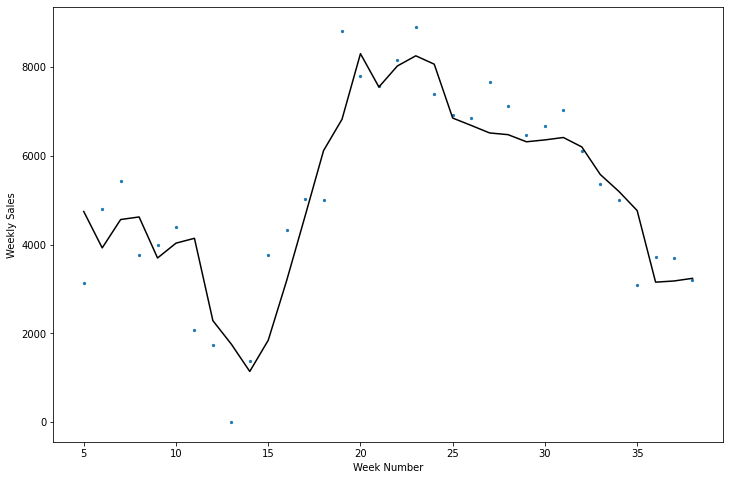

In [36]:
# Get more info on specific case:
st_id = 16
y_temp = np.squeeze(y_ws_train[y_st_train[:] == st_id])
y_temp = np.concatenate((y_temp[len(y_ws_train)-9:], y_ws_y3[y_st_y3[:] == st_id]), axis=0)
scale = np.max(y_temp)

lstm_id = ts_lstm_model(y_temp, look_back, epochs*38)

X_temp = X_train[y_st_train[:] == st_id]
y_testX, y_testY = create_dataset(y_temp, look_back)

y_hat = np.squeeze(lstm_id.predict(y_testX)) * scale
y_testY = y_testY * scale

print(str(st_id) + "    " + str(np.corrcoef(y_testY, y_hat)[0, 1]**2) + "    " + str((np.square(y_testY - y_hat)).mean(axis=0)))
plt.figure(figsize=(12, 8))
plt.scatter(X_temp[:len(y_hat), 0], y_testY, s=5)
plt.plot(X_temp[:len(y_hat), 0], y_hat, color='#000000')
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.show()

## Prophet

In [0]:
start_training_date = int(min(X_train[:, 0]))
end_training_date = int(max(X_train[:, 0]))
start_forcasting_date = int(min(X_y3[:, 0]))
end_forcasting_date = int(max(X_y3[:, 0]))

# Inputs for forcasting
future_num_points = int(days_between(start_forcasting_date, end_forcasting_date)) + 1
cap = None # 2e6
growth = 'linear'
n_changepoints = 25 
changepoint_prior_scale = 0.05 
changepoints = None 
holidays_prior_scale = 10 
interval_width = 0.8 
mcmc_samples = 0

holidays = None
daily_seasonality = False
weekly_seasonality = True
yearly_seasonality = True

plot_stuff = False

1    0.34736107801600735


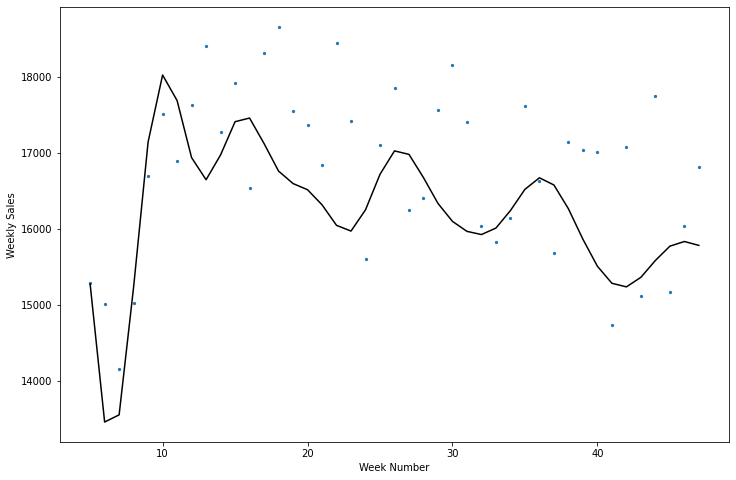

2    0.44540701418264167


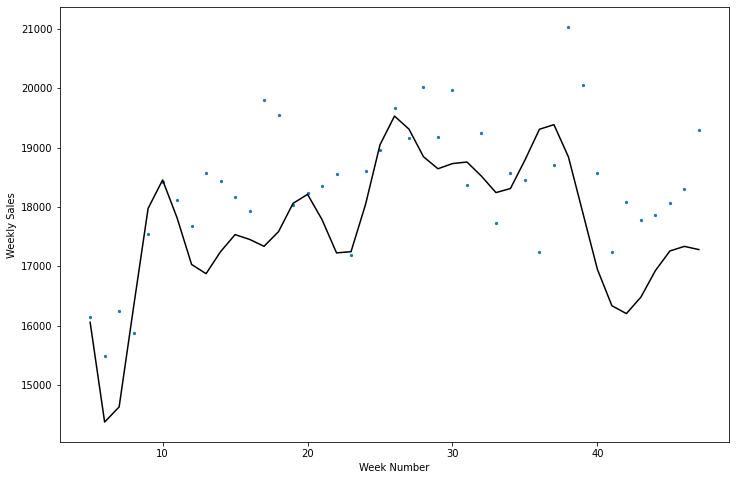

3    0.4471916917379511


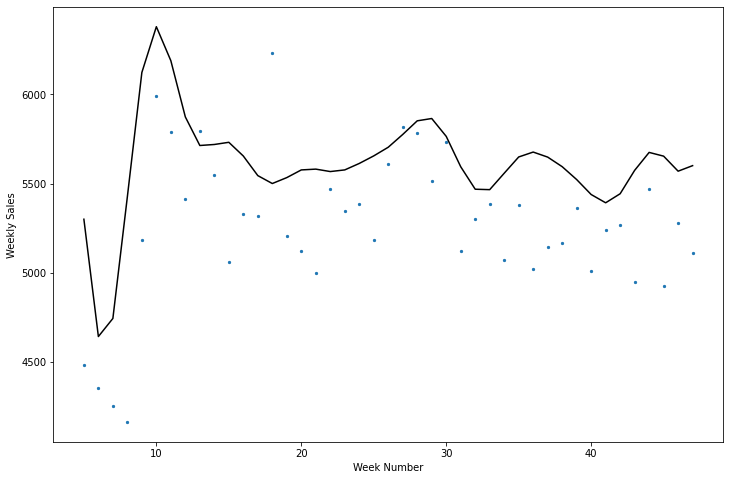

4    0.30727806667602736


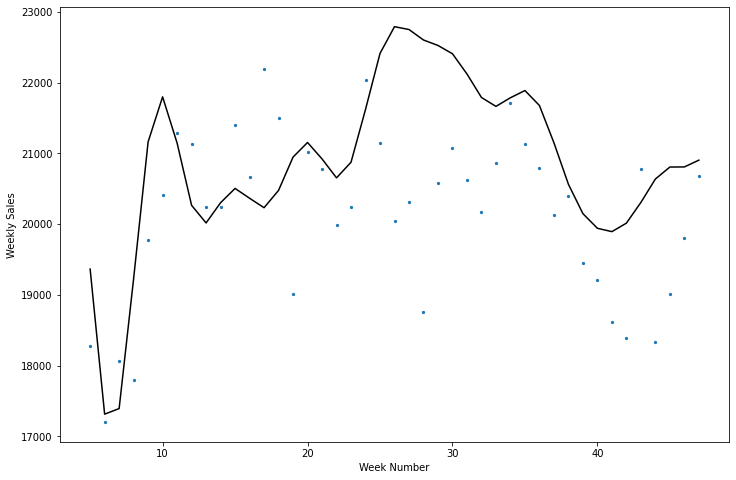

5    0.39947301559915055


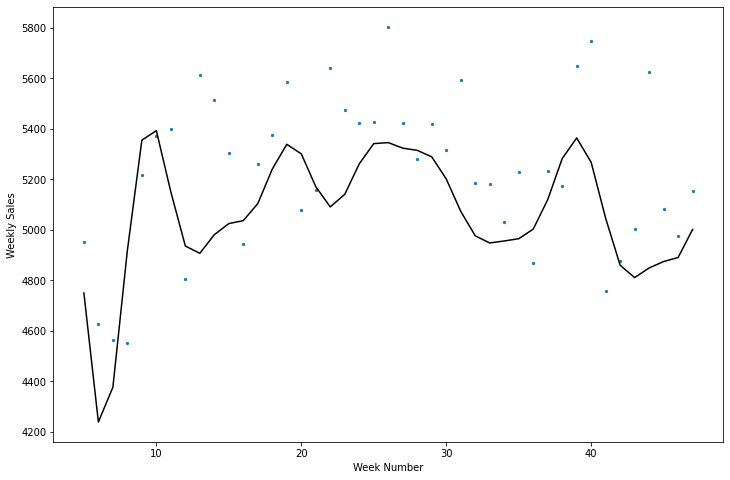

6    0.6752106754197144


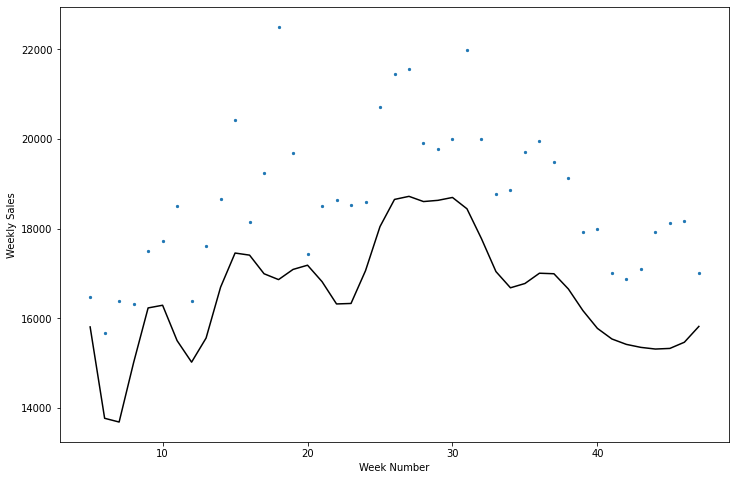

7    0.7951982511239402


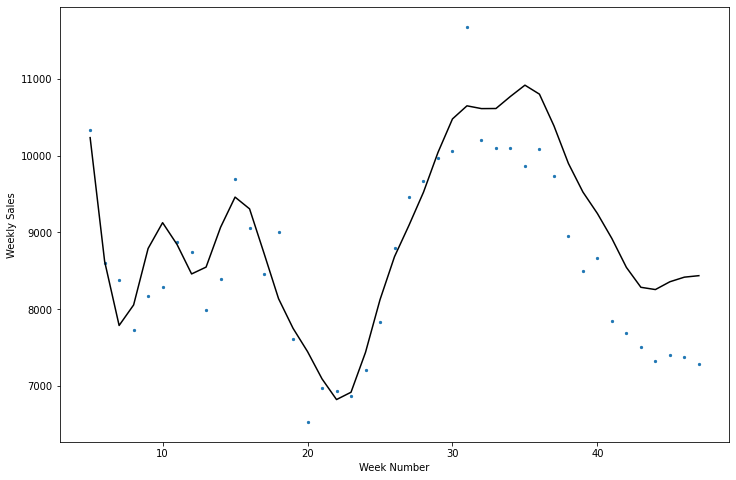

8    0.4511618360269633


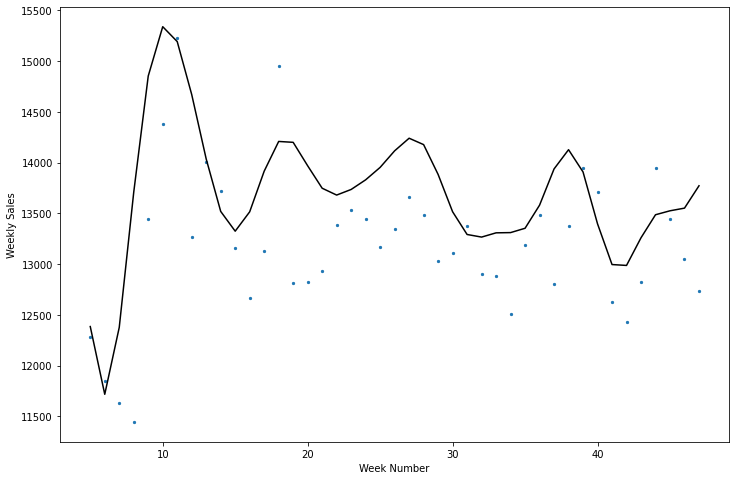

9    0.32794914152585697


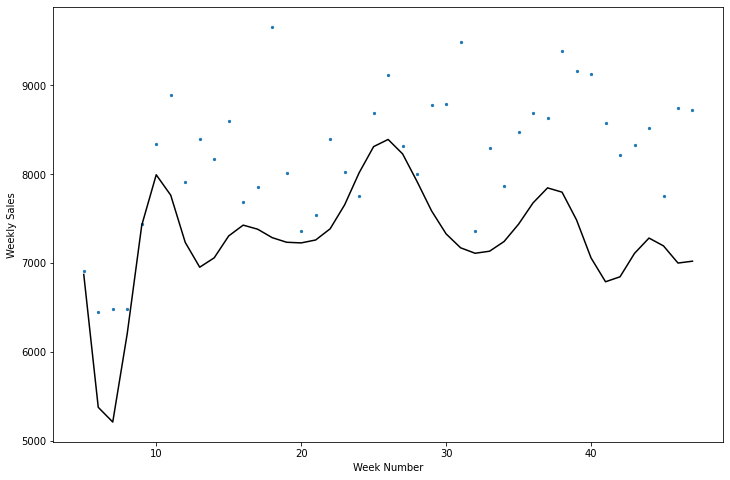

10    0.5714212307991821


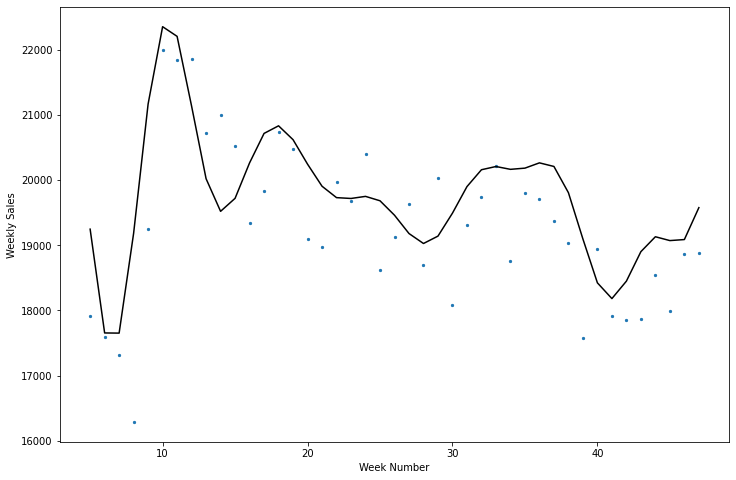

11    0.2512893052162953


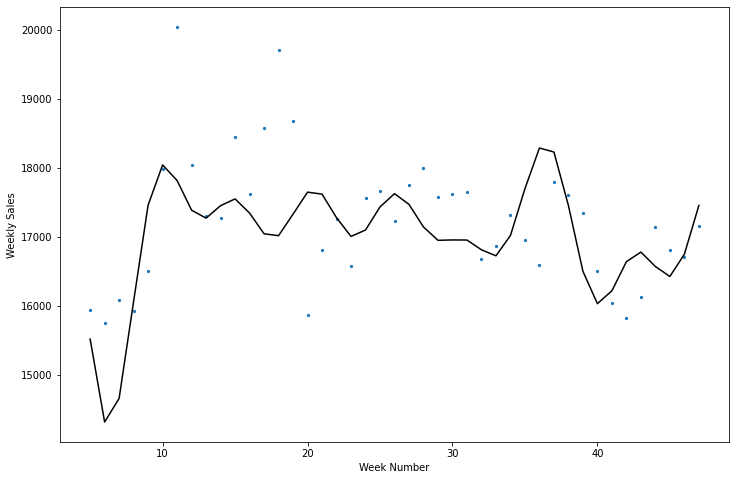

12    0.2603045593391837


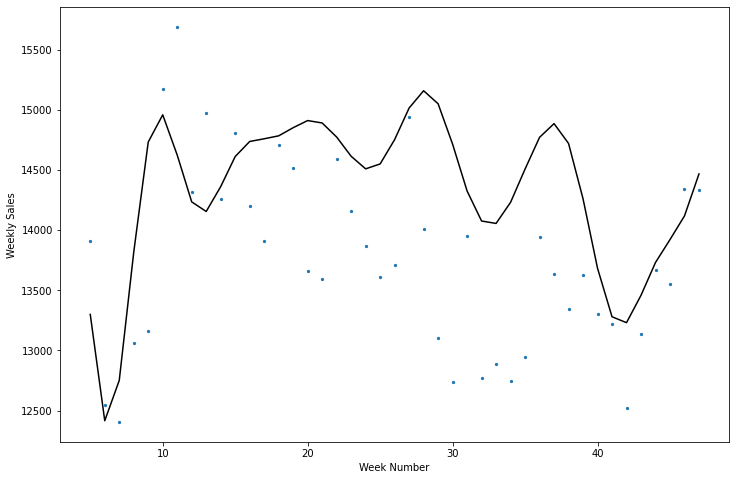

13    0.5573340329692545


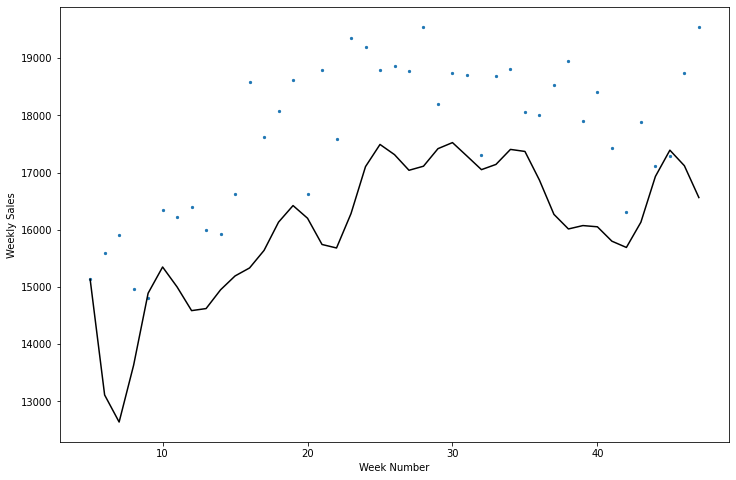

14    0.2627503908944313


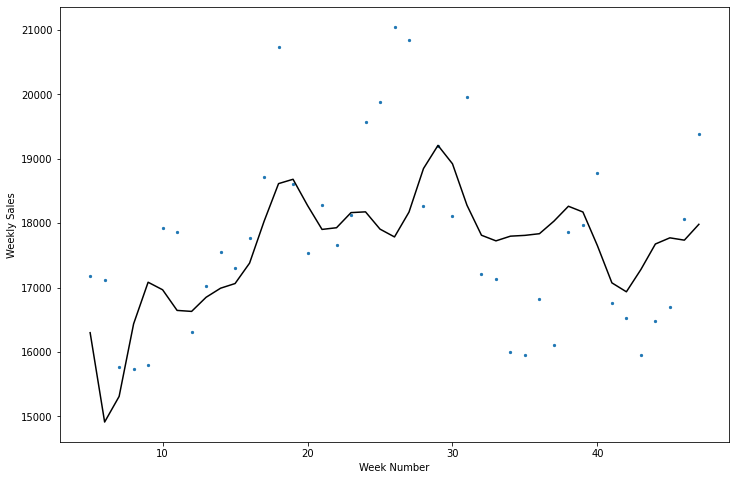

15    0.6823700760599287


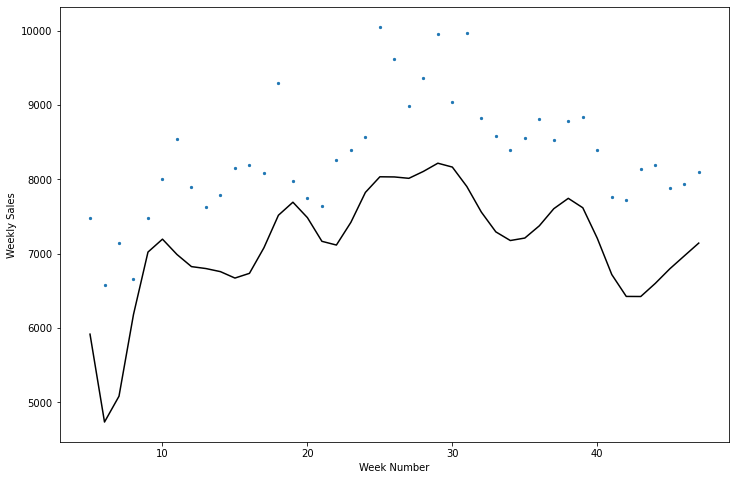

16    0.8384966905435507


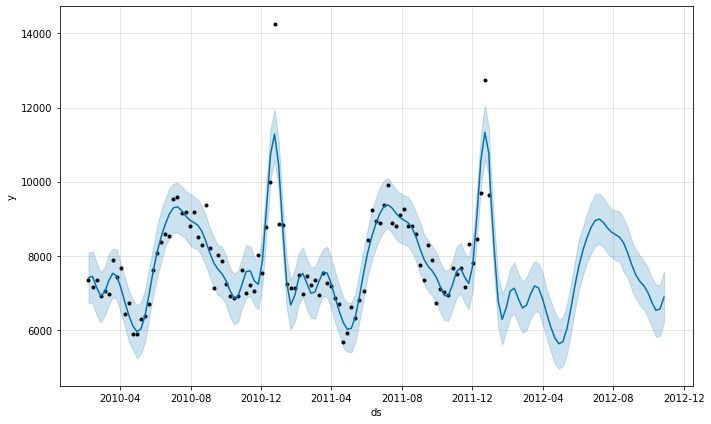

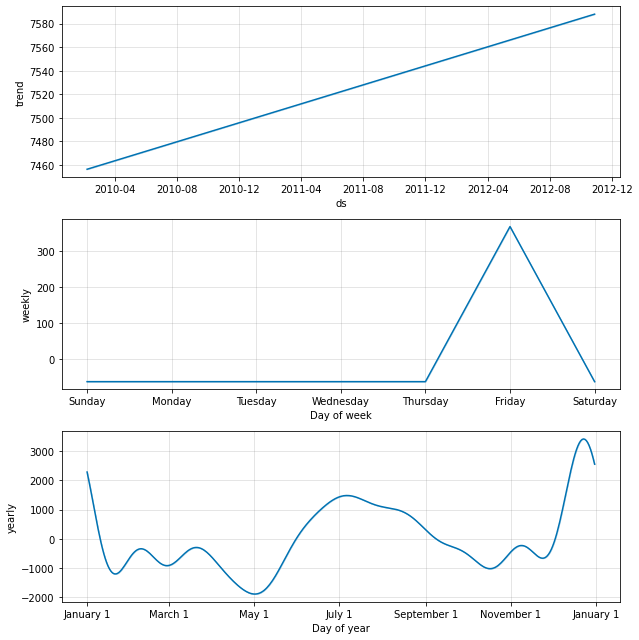

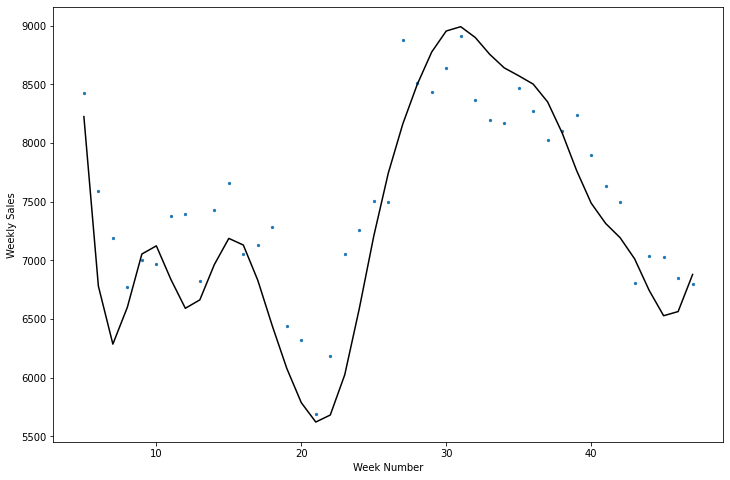

16    0.8384966905435507


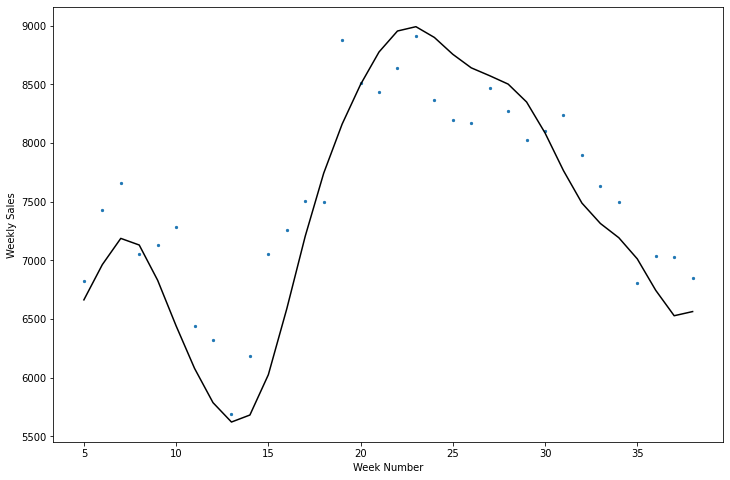

17    0.47497128506946834


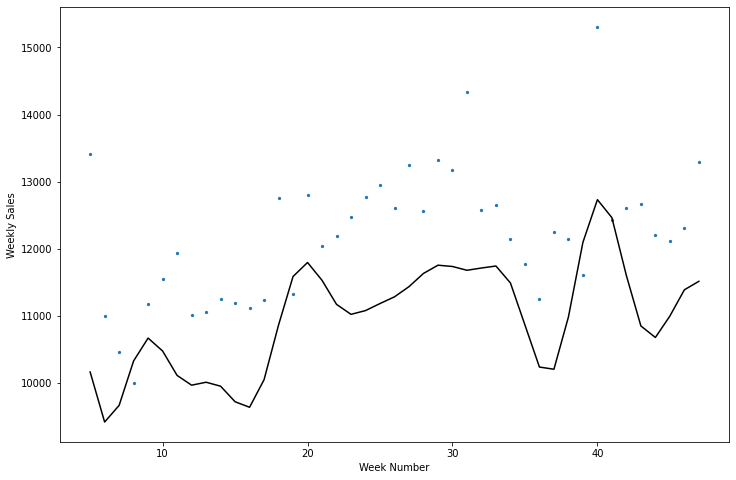

18    0.3346651088720673


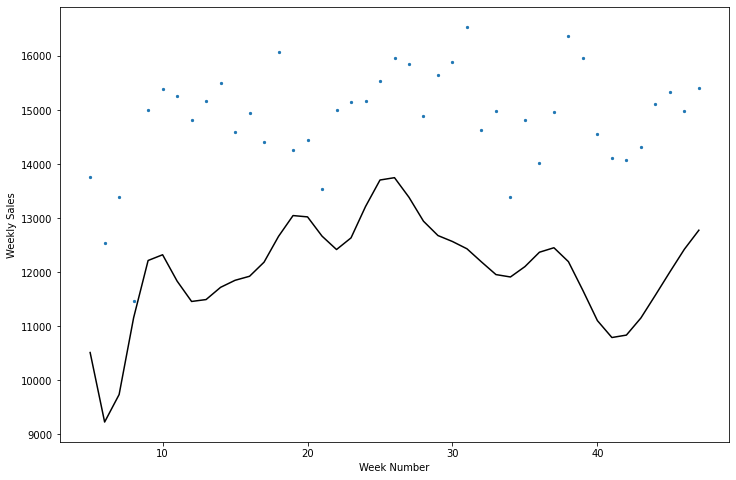

19    0.6757099590738738


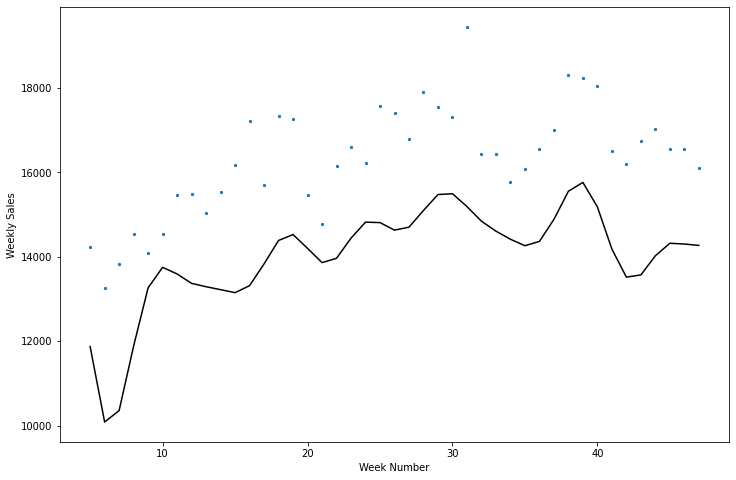

20    0.3652552246566416


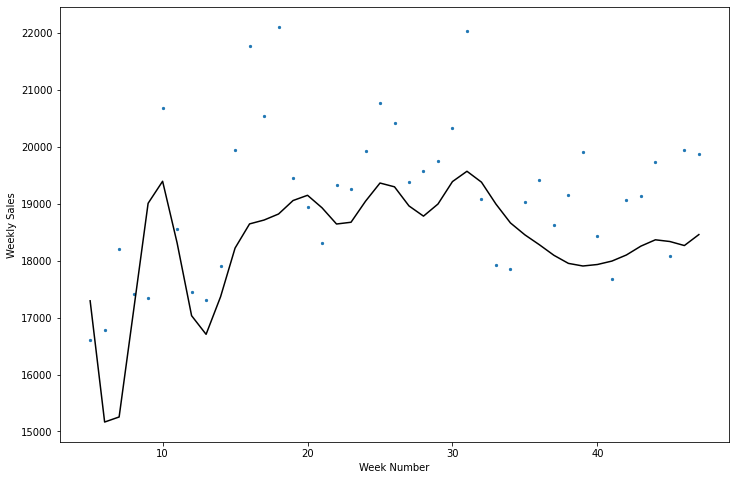

21    0.5826309590543749


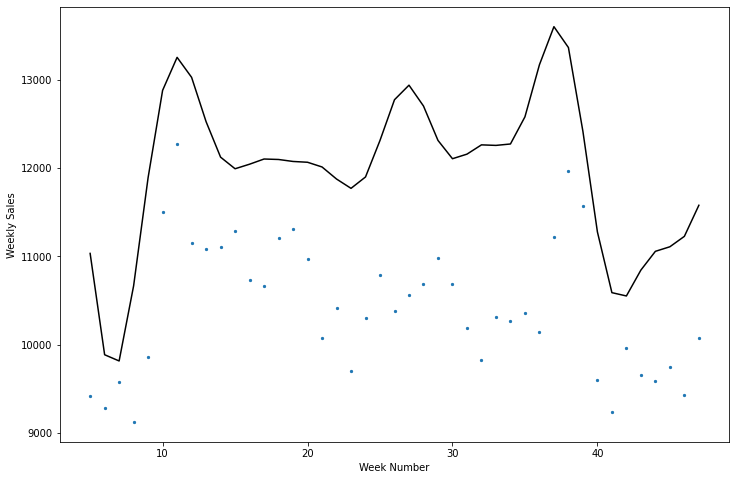

22    0.5763997427516834


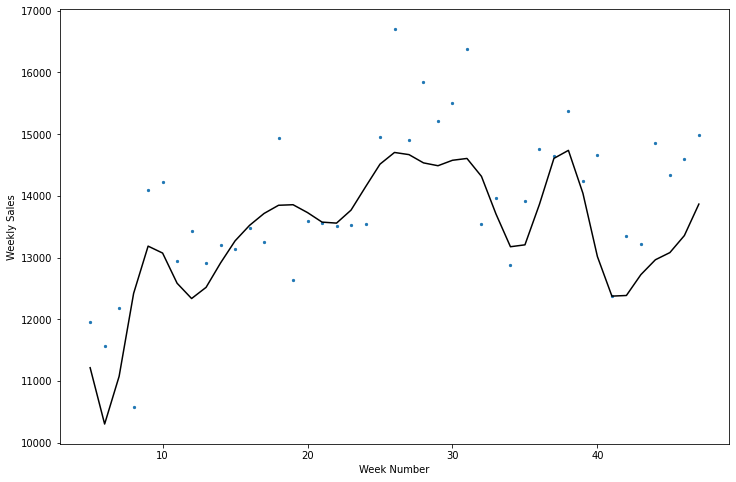

23    0.7572094694356808


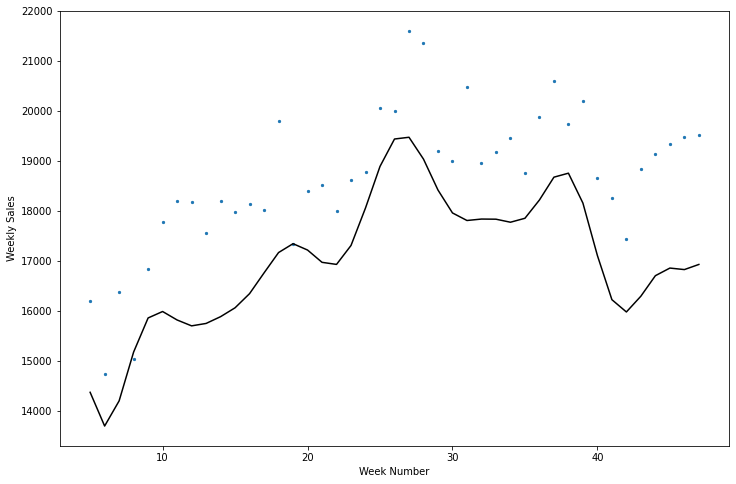

24    0.67425116260612


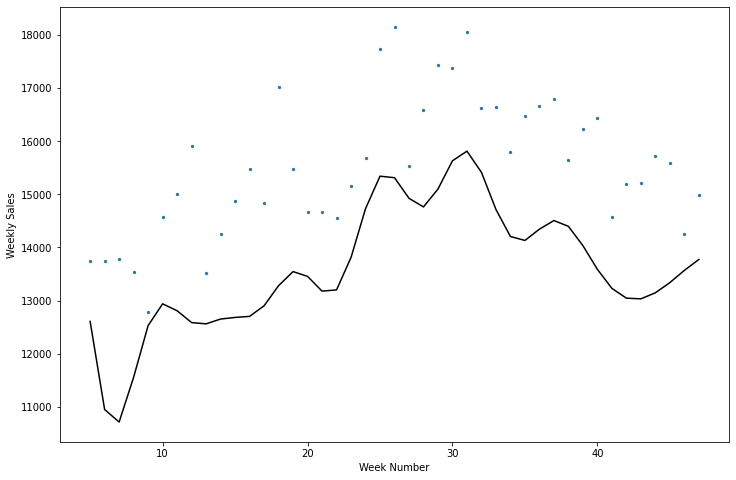

25    0.6376906636732999


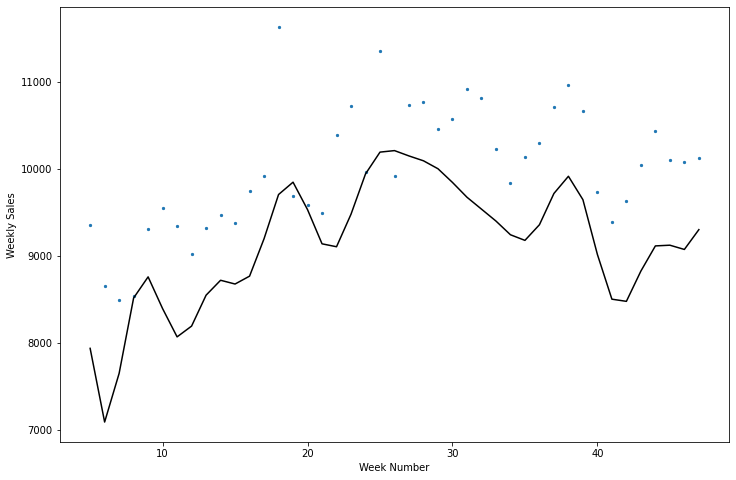

26    0.5012570643690517


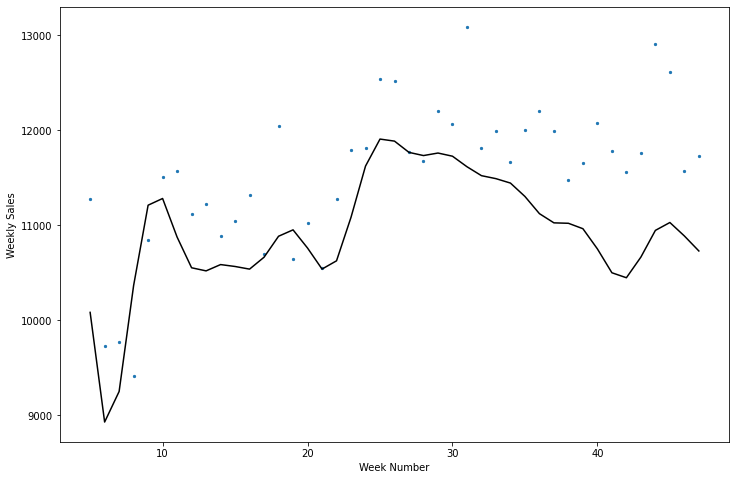

27    0.5321002443156544


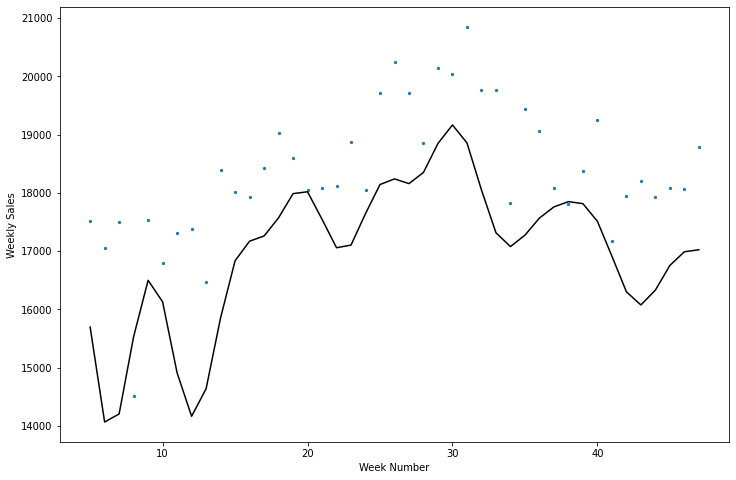

28    0.5496238285536746


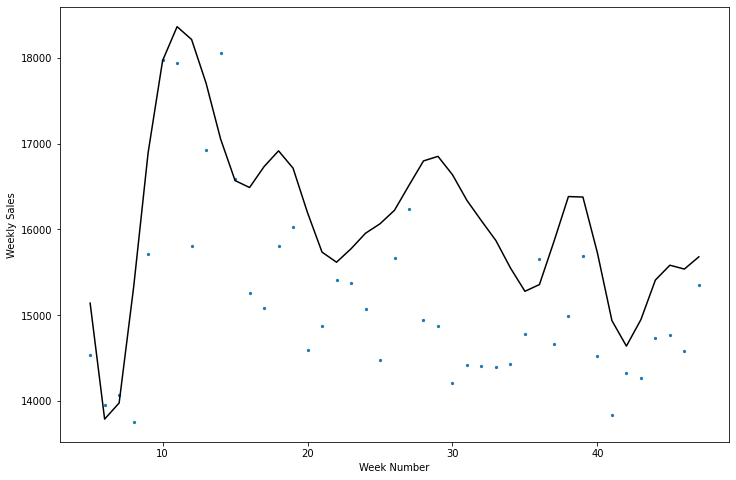

29    0.5112146108086206


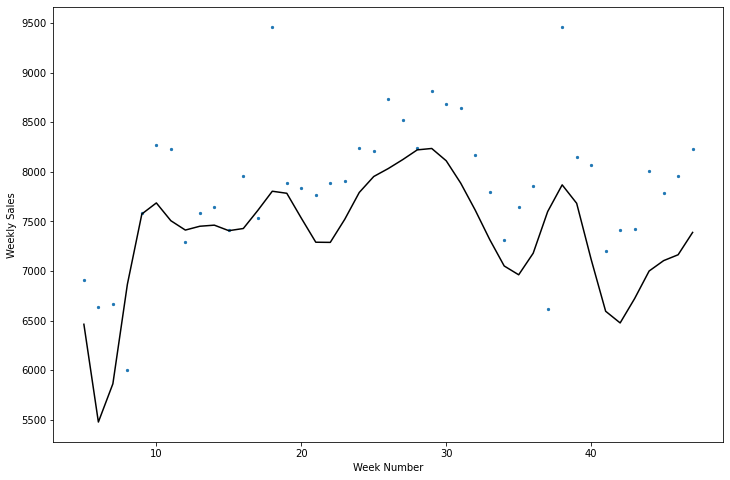

30    0.0011778024154671936


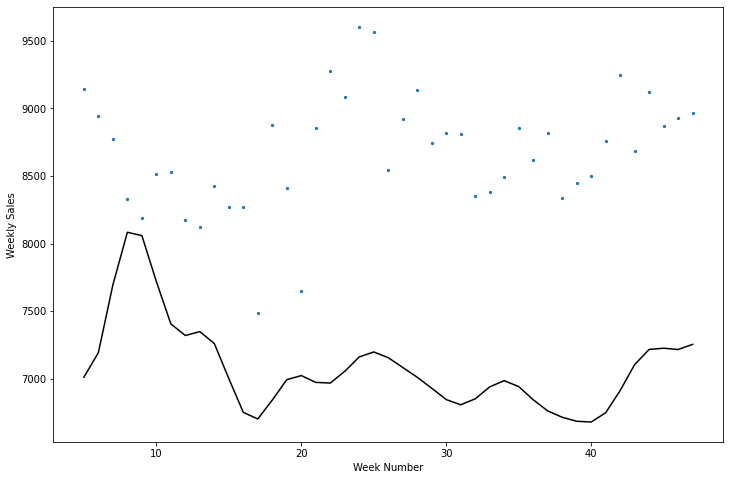

31    0.03956991357487829


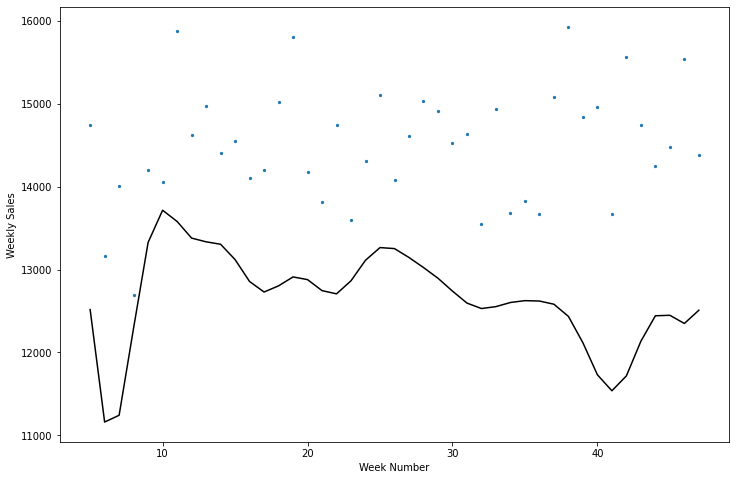

32    0.47282871582004704


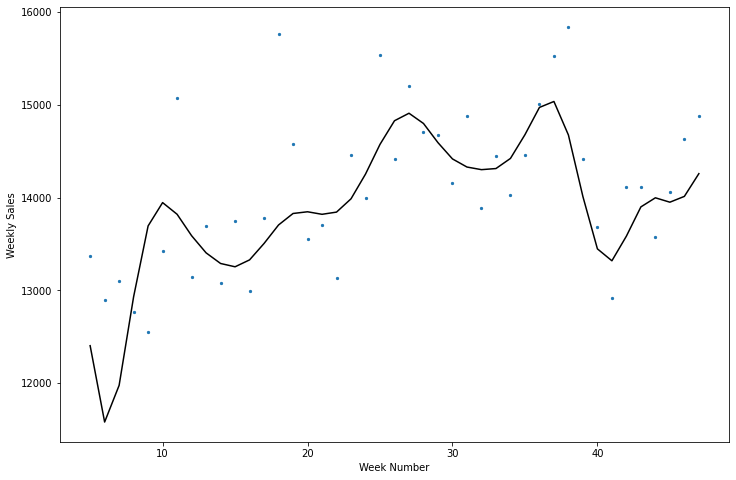

33    0.0023334664551614894


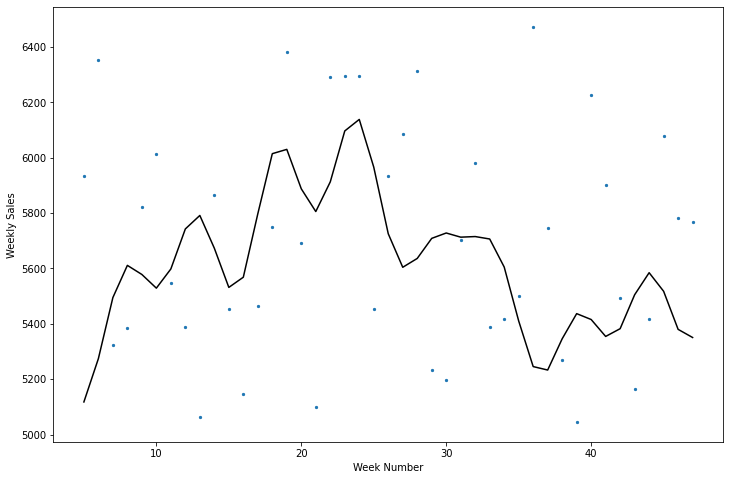

34    0.45633822990302453


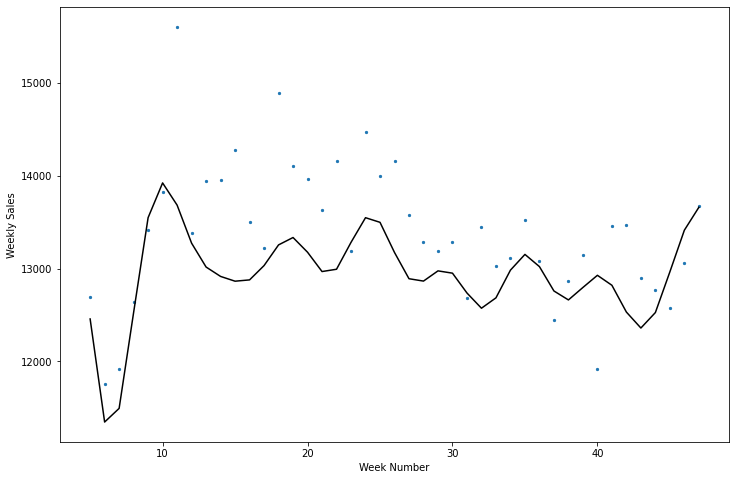

35    0.5960202708232598


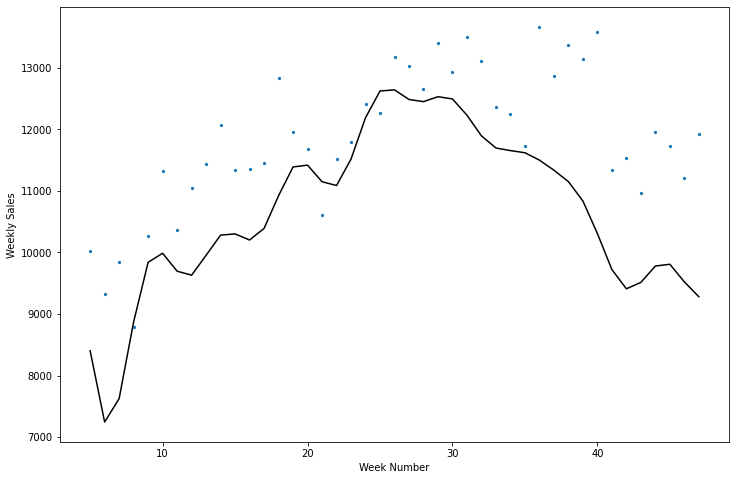

In [30]:
set_start = '2010-02-05'
set_start = datetime.strptime(set_start, '%Y-%m-%d')
R2 = []
MSE = []

for i in range(len(np.unique(y_st_y3))):  # For each unique store predicted, evaluate

  ds = X_train[:, 0][y_st_train == i+1].astype(int)
  new_ds = np.empty(shape=(len(ds),1)).astype(str)
  for j in range(len(ds)):  # Fix dates back to date from weeks because prophet
    # print(type(int(ds[i]-5)))
    temp = set_start + timedelta(weeks = int(ds[j]-5))
    new_ds[j] = temp.strftime('%Y-%m-%d')
  ds = new_ds

  y = y_ws_train[y_st_train == i + 1]
  y_test = y_ws_y3[y_st_y3 == i + 1]

  df = np.concatenate((ds, y), axis=1)
  df = pd.DataFrame(df, columns = ['ds', 'y'])
  # print(df.head())
  df_prophet = df
  # df_prophet = df_prophet.reset_index()
  # print(df_prophet)

  if i+1 == 16:
    plot_stuff = True
  else:
    plot_stuff = False
  forecast = weekly_forecast(df_prophet, holidays, growth, n_changepoints, holidays_prior_scale,
                        changepoint_prior_scale, changepoints, interval_width, mcmc_samples, 
                        future_num_points, daily_seasonality=daily_seasonality, 
                        weekly_seasonality=weekly_seasonality, yearly_seasonality=yearly_seasonality, 
                        plot_stuff=plot_stuff)

  # print(forecast.columns.values)
  # print(forecast.head())
  # print(forecast.tail())  # Last date should be 2012-10-26
  y_hat = forecast['yhat'].to_numpy()[end_training_date-3:]
  # print(y_test.shape)
  # print(y_hat.shape)

  R2.append(np.corrcoef(y_test, y_hat)[0, 1]**2)
  MSE.append((np.square(y_test - y_hat)).mean(axis=0))

  if R2[i] > 0.0:
    print(str(i+1) + "    " + str(R2[i]))
    plt.figure(figsize=(12, 8))
    plt.scatter(X_temp[:len(y_hat), 0], y_test, s=5)
    plt.plot(X_temp[:len(y_hat), 0], y_hat, color='#000000')
    plt.xlabel('Week Number')
    plt.ylabel('Weekly Sales')
    plt.show()

  if i+1 == st_id:
    print(str(i+1) + "    " + str(R2[i]))
    plt.figure(figsize=(12, 8))
    plt.scatter(X_temp[:len(y_hat)-9, 0], y_test[8:len(y_test)-1], s=5)
    plt.plot(X_temp[:len(y_hat)-9, 0], y_hat[8:len(y_test)-1], color='#000000')
    plt.xlabel('Week Number')
    plt.ylabel('Weekly Sales')
    plt.show()

In [31]:
print(R2)
r2 = np.max(R2)
print("LSTM Max R^2 Value: " + str(r2))
print(MSE)
mse = np.min(MSE)
print("LSTM MSE: " + str(mse))

[0.34736107801600735, 0.44540701418264167, 0.4471916917379511, 0.30727806667602736, 0.39947301559915055, 0.6752106754197144, 0.7951982511239402, 0.4511618360269633, 0.32794914152585697, 0.5714212307991821, 0.2512893052162953, 0.2603045593391837, 0.5573340329692545, 0.2627503908944313, 0.6823700760599287, 0.8384966905435507, 0.47497128506946834, 0.3346651088720673, 0.6757099590738738, 0.3652552246566416, 0.5826309590543749, 0.5763997427516834, 0.7572094694356808, 0.67425116260612, 0.6376906636732999, 0.5012570643690517, 0.5321002443156544, 0.5496238285536746, 0.5112146108086206, 0.0011778024154671936, 0.03956991357487829, 0.47282871582004704, 0.0023334664551614894, 0.45633822990302453, 0.5960202708232598]
LSTM Max R^2 Value: 0.8384966905435507
[1153569.7485389842, 1297255.7572915072, 215178.3365574417, 1799712.9430603692, 87641.18739368036, 5237417.729965185, 409818.2737490598, 575532.3176960384, 1293934.2994619503, 862701.3423326, 837184.7545448015, 810415.4096762328, 3326029.109489430